# library importing

In [ ]:
# !pip install math json csv dis platform statistics subprocess requests

In [77]:
import os
import json
import csv
import dis
import json
import math
import re
import platform
import statistics
import subprocess
import requests
import zipfile
import os
import shutil
import random
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from typing import Dict, Tuple, Callable, Any, Optional, List
from types import MappingProxyType
from tqdm.auto import tqdm

# constants

In [63]:
CARBON_INTENSITY_API = "https://api.carbonintensity.org.uk/intensity"
DEFAULT_CARBON_INTENSITY = 0.2  # Fallback value in kgCO2/kWh
DEFAULT_COST_MODEL_PATH = "./cost_models"
DEFAULT_EXAMPLES_PATH = "./examples"
SAVING_FLAG = True
DEFAULT_REPORT_DIR = "./enhanced_reports"

# Default weights for composite score calculation
DEFAULT_COMPOSITE_WEIGHTS = {
    "CU": 0.35,    # Computational cost weight
    "EU": 0.25,    # Energy weight
    "CO2": 0.25,   # Environmental weight
    "$": 0.15      # Monetary weight
}
RESEARCH_WEIGHTS = {
    "CU": 0.40, # Performance is the most important
    "EU": 0.30, # Energy is important
    "CO2": 0.25, # Environment is important
    "$": 0.05 # Cost is minimal
}
COMMERCIAL_WEIGHTS = {
    "CU": 0.30, # Performance is important
    "EU": 0.20, # Energy is a medium priority
    "CO2": 0.20, # Environment is a medium priority
    "$": 0.30 # Cost is a high priority
}
MOBILE_WEIGHTS = {
    "CU": 0.25, # Performance is important, but not critical
    "EU": 0.50, # Energy is the top priority
    "CO2": 0.15, # Environment is a medium priority
    "$": 0.10 # Cost is a low priority
}
HPC_WEIGHTS = {
    "CU": 0.50, # Productivity is the most important
    "EU": 0.30, # Energy is the second priority
    "CO2": 0.15, # Environment is important, but not critical
    "$": 0.05 # Cost is less important
}
# Reference values for normalization (can be calibrated based on benchmark suite)
REFERENCE_VALUES = {
    "CU": {"min": 1.0, "max": 1000.0, "typical": 100.0},
    "EU": {"min": 0.0001, "max": 10.0, "typical": 1.0},
    "CO2": {"min": 0.00001, "max": 1.0, "typical": 0.1},
    "$": {"min": 0.000001, "max": 0.1, "typical": 0.01}
}

PROFILE_WEIGHTS = MappingProxyType({
    "RESEARCH": RESEARCH_WEIGHTS,
    "COMMERCIAL": COMMERCIAL_WEIGHTS,
    "MOBILE": MOBILE_WEIGHTS,
    "HPC": HPC_WEIGHTS,
    "DEFAULT": DEFAULT_COMPOSITE_WEIGHTS,
})

os.makedirs(DEFAULT_COST_MODEL_PATH[2:], exist_ok=True)
os.makedirs(DEFAULT_EXAMPLES_PATH[2:], exist_ok=True)

def process_zip_file(zip_filename, target_directory):
    """
    Распаковывает zip-файл в указанную директорию и удаляет архив
    """
    # Путь к zip-файлу в корне /content/
    zip_path = f'/content/{zip_filename}'

    # Проверяем существование zip-файла
    if not os.path.exists(zip_path):
        print(f"Ошибка: файл {zip_path} не найден!")
        return False

    # Создаем целевую директорию если не существует
    os.makedirs(target_directory, exist_ok=True)

    try:
        # Открываем и распаковываем zip-файл
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            print(f"Распаковка {zip_filename}...")

            # Получаем список файлов в архиве
            file_list = zip_ref.namelist()
            print(f"Найдено файлов в архиве: {len(file_list)}")

            # Распаковываем все файлы в целевую директорию
            zip_ref.extractall(target_directory)

            # Выводим информацию о распакованных файлах
            for file_name in file_list:
                extracted_path = os.path.join(target_directory, file_name)
                if os.path.isfile(extracted_path):
                    file_size = os.path.getsize(extracted_path)
                    print(f"Извлечен: {file_name} ({file_size} байт)")

        # Удаляем zip-файл после успешной распаковки
        os.remove(zip_path)
        print(f"Zip-файл {zip_filename} удален")

        print(f"Операция завершена успешно! Файлы сохранены в: {target_directory}")
        return True

    except zipfile.BadZipFile:
        print(f"Ошибка: {zip_filename} поврежден или не является zip-файлом")
        return False
    except Exception as e:
        print(f"Ошибка при обработке: {str(e)}")
        return False

zip_filename_models = "cost_models.zip"
zip_filename_examples = "examples.zip"

process_zip_file(zip_filename_models, DEFAULT_COST_MODEL_PATH)
process_zip_file(zip_filename_examples, DEFAULT_EXAMPLES_PATH)

Ошибка: файл /content/cost_models.zip не найден!
Ошибка: файл /content/examples.zip не найден!


False

In [ ]:
!wget https://example.com/file.zip

# needed functions and classes

In [81]:
class CompositeScoreCalculator:
    """
    Calculator for unified composite scores based on multiple cost metrics.

    Provides normalization, scaling, and weighted combination of cost metrics
    into a single composite score for algorithm comparison.
    """

    def __init__(self, weights: Optional[Dict[str, float]] = None,
                 profile: Optional[str] = None,
                 reference_values: Optional[Dict[str, Dict[str, float]]] = None):
        """
        Initialize composite score calculator.

        Args:
            weights: Weight distribution for metrics (must sum to 1.0)
            profile: Predefined profile name ('HPC', 'MOBILE', 'COMMERCIAL', 'RESEARCH', 'DEFAULT')
            reference_values: Reference values for normalization
        """
        if weights is not None:
            self.weights = weights.copy()
        elif profile is not None:
            if profile not in PROFILE_WEIGHTS:
                raise ValueError(f"Unknown profile: {profile}. Available: {list(PROFILE_WEIGHTS.keys())}")
            self.weights = PROFILE_WEIGHTS[profile].copy()
        else:
            self.weights = DEFAULT_COMPOSITE_WEIGHTS.copy()

        self.profile = profile or "CUSTOM"
        self.reference_values = reference_values or REFERENCE_VALUES.copy()

        # Validate weights sum to 1.0
        weight_sum = sum(self.weights.values())
        if abs(weight_sum - 1.0) > 1e-6:
            raise ValueError(f"Weights must sum to 1.0, got {weight_sum}")

    def normalize_metric(self, value: float, metric: str, method: str = "minmax") -> float:
        """
        Normalize a metric value to 0-100 scale.

        Args:
            value: Raw metric value
            metric: Metric name (CU, EU, CO2, $)
            method: Normalization method ('minmax', 'zscore', 'log')

        Returns:
            Normalized score (0-100)
        """
        if metric not in self.reference_values:
            return 50.0  # Default middle value for unknown metrics

        ref = self.reference_values[metric]
        min_val, max_val = ref["min"], ref["max"]

        if method == "minmax":
            # Min-max normalization with inversion (lower is better)
            if max_val <= min_val:
                return 50.0
            normalized = (value - min_val) / (max_val - min_val)
            # Invert: lower cost = higher score
            return max(0.0, min(100.0, 100.0 * (1.0 - normalized)))

        elif method == "zscore":
            # Z-score normalization using typical value as mean
            typical = ref["typical"]
            std_estimate = (max_val - min_val) / 6  # Rough 6-sigma estimate
            if std_estimate <= 0:
                return 50.0
            z_score = (value - typical) / std_estimate
            # Convert to percentile and invert
            percentile = self._z_to_percentile(-z_score)  # Negative for inversion
            return max(0.0, min(100.0, percentile))

        elif method == "log":
            # Logarithmic normalization for highly skewed data
            if value <= 0 or min_val <= 0 or max_val <= min_val:
                return 50.0
            log_val = math.log(value)
            log_min = math.log(min_val)
            log_max = math.log(max_val)
            normalized = (log_val - log_min) / (log_max - log_min)
            return max(0.0, min(100.0, 100.0 * (1.0 - normalized)))

        else:
            raise ValueError(f"Unknown normalization method: {method}")

    def _z_to_percentile(self, z_score: float) -> float:
        """Convert z-score to percentile using approximation."""
        # Approximation of cumulative normal distribution
        return 50.0 * (1.0 + math.erf(z_score / math.sqrt(2)))

    def calculate_composite_score(self, metrics: Dict[str, float],
                                method: str = "minmax") -> Dict[str, float]:
        """
        Calculate composite score from individual metrics.

        Args:
            metrics: Dictionary with raw metric values
            method: Normalization method to use

        Returns:
            Dictionary with normalized scores and composite score
        """
        normalized_scores = {}

        # Normalize each metric
        for metric, value in metrics.items():
            if metric in self.weights:
                normalized_scores[f"{metric}_normalized"] = self.normalize_metric(
                    value, metric, method
                )

        # Calculate weighted composite score
        composite_score = 0.0
        for metric, weight in self.weights.items():
            normalized_key = f"{metric}_normalized"
            if normalized_key in normalized_scores:
                composite_score += weight * normalized_scores[normalized_key]

        # Add composite score to results
        result = metrics.copy()
        result.update(normalized_scores)
        result["COMPOSITE_SCORE"] = composite_score

        # Add score interpretation
        result["SCORE_GRADE"] = self._get_score_grade(composite_score)
        result["EFFICIENCY_RATING"] = self._get_efficiency_rating(composite_score)

        return result

    def _get_score_grade(self, score: float) -> str:
        """Convert numeric score to letter grade."""
        if score >= 90: return "A+"
        elif score >= 85: return "A"
        elif score >= 80: return "A-"
        elif score >= 75: return "B+"
        elif score >= 70: return "B"
        elif score >= 65: return "B-"
        elif score >= 60: return "C+"
        elif score >= 55: return "C"
        elif score >= 50: return "C-"
        elif score >= 40: return "D"
        else: return "F"

    def _get_efficiency_rating(self, score: float) -> str:
        """Convert numeric score to efficiency rating."""
        if score >= 85: return "Excellent"
        elif score >= 70: return "Good"
        elif score >= 55: return "Average"
        elif score >= 40: return "Below Average"
        else: return "Poor"

    def update_reference_values(self, benchmark_results: List[Dict[str, float]]) -> None:
        """
        Update reference values based on benchmark results.

        Args:
            benchmark_results: List of metric dictionaries from benchmark runs
        """
        if not benchmark_results:
            return

        for metric in self.weights.keys():
            values = [result.get(metric, 0) for result in benchmark_results if metric in result]
            if values:
                self.reference_values[metric] = {
                    "min": min(values),
                    "max": max(values),
                    "typical": statistics.median(values)
                }

    def get_profile_info(self) -> Dict[str, Any]:
        """
        Get information about current weight profile.

        Returns:
            Dictionary with profile information
        """
        return {
            "profile": self.profile,
            "weights": self.weights.copy(),
            "description": self._get_profile_description()
        }

    def _get_profile_description(self) -> str:
        """Get description of current profile."""
        descriptions = {
            "HPC": "High Performance Computing - optimized for maximum computational throughput",
            "MOBILE": "Mobile/IoT - optimized for energy efficiency and battery life",
            "COMMERCIAL": "Commercial Cloud - balanced approach with cost consideration",
            "RESEARCH": "Research/Academic - focused on performance with environmental awareness",
            "DEFAULT": "Default balanced profile for general use cases",
            "CUSTOM": "Custom weight configuration"
        }
        return descriptions.get(self.profile, "Custom profile configuration")


class InstructionCostModel:
    """
    Model for instruction costs across different architectures.

    Loads cost models from JSON files and provides cost lookup functionality
    for different instruction types across various metrics (CU, EU, CO2, $).
    """

    def __init__(self, arch: str) -> None:
        """
        Initialize instruction cost model for specified architecture.

        Args:
            arch: Target architecture (e.g., 'x86', 'arm', 'gpu')

        Raises:
            RuntimeError: If cost model file for architecture is not found
        """
        self.arch = arch.lower()
        self.weights = self._load_weights()
        self.bytecode_mapping = self._get_bytecode_mapping()

    def _load_weights(self) -> Dict[str, Dict[str, float]]:
        """
        Load instruction weights from architecture-specific JSON file.

        Returns:
            Dictionary mapping instruction names to cost metrics

        Raises:
            RuntimeError: If cost model file cannot be loaded
        """
        # Try multiple ways to find the correct path
        possible_paths = []

        # Method 1: Use __file__ if available
        try:
            script_dir = os.path.dirname(os.path.abspath(__file__))
            possible_paths.append(os.path.join(script_dir, f"cost_models/{self.arch}_instr_costs.json"))
        except NameError:
            pass

        # Method 2: Current working directory
        possible_paths.append(f"cost_models/{self.arch}_instr_costs.json")

        # Method 3: Relative to current directory
        possible_paths.append(f"./{self.arch}_instr_costs.json")

        # Method 4: Check if DEFAULT_COST_MODEL_PATH exists
        if os.path.exists(DEFAULT_COST_MODEL_PATH):
            possible_paths.append(
                os.path.join(DEFAULT_COST_MODEL_PATH, f"{self.arch}_instr_costs.json")
            )

        # Try each path until one works
        for model_file in possible_paths:
            try:
                if os.path.exists(model_file):
                    with open(model_file, 'r', encoding='utf-8') as f:
                        return json.load(f)
            except (FileNotFoundError, json.JSONDecodeError, PermissionError):
                continue

        # If no file found, use default fallback model
        print(f"Warning: Cost model not found for architecture: {self.arch}. Using default values.")
        return self._get_default_cost_model()

    def _get_default_cost_model(self) -> Dict[str, Dict[str, float]]:
        """Get default cost model when no file is available."""
        return {
            "ADD": {"CU": 1.0, "EU": 0.0001, "CO2": 0.00005, "$": 0.00001},
            "SUB": {"CU": 1.0, "EU": 0.0001, "CO2": 0.00005, "$": 0.00001},
            "MUL": {"CU": 3.0, "EU": 0.0003, "CO2": 0.00015, "$": 0.00003},
            "DIV": {"CU": 10.0, "EU": 0.001, "CO2": 0.0005, "$": 0.0001},
            "LOAD": {"CU": 2.0, "EU": 0.0002, "CO2": 0.0001, "$": 0.00002},
            "STORE": {"CU": 2.0, "EU": 0.0002, "CO2": 0.0001, "$": 0.00002},
            "JMP": {"CU": 1.5, "EU": 0.00015, "CO2": 0.000075, "$": 0.000015},
            "CALL": {"CU": 5.0, "EU": 0.0005, "CO2": 0.00025, "$": 0.00005},
            "MOV": {"CU": 1.0, "EU": 0.0001, "CO2": 0.00005, "$": 0.00001},
            "AND": {"CU": 1.0, "EU": 0.0001, "CO2": 0.00005, "$": 0.00001},
            "OR": {"CU": 1.0, "EU": 0.0001, "CO2": 0.00005, "$": 0.00001},
            "XOR": {"CU": 1.0, "EU": 0.0001, "CO2": 0.00005, "$": 0.00001}
        }

    def _get_bytecode_mapping(self) -> Dict[str, str]:
        """
        Get mapping from Python bytecode instructions to architecture instructions.

        Returns:
            Dictionary mapping bytecode ops to architecture ops
        """
        return {
            'BINARY_ADD': 'ADD',
            'BINARY_SUBTRACT': 'SUB',
            'BINARY_MULTIPLY': 'MUL',
            'BINARY_TRUE_DIVIDE': 'DIV',
            'BINARY_FLOOR_DIVIDE': 'DIV',
            'BINARY_AND': 'AND',
            'BINARY_OR': 'OR',
            'BINARY_XOR': 'XOR',
            'LOAD_CONST': 'LOAD',
            'LOAD_FAST': 'LOAD',
            'LOAD_GLOBAL': 'LOAD',
            'STORE_FAST': 'STORE',
            'STORE_GLOBAL': 'STORE',
            'STORE_NAME': 'STORE',
            'JUMP_FORWARD': 'JMP',
            'JUMP_IF_TRUE_OR_POP': 'JMP',
            'JUMP_IF_FALSE_OR_POP': 'JMP',
            'CALL_FUNCTION': 'CALL',
            'RETURN_VALUE': 'MOV'
        }

    def get_cost(self, opname: str, is_bytecode: bool = False) -> Tuple[float, float, float, float]:
        """
        Get cost metrics for specified instruction.

        Args:
            opname: Instruction operation name
            is_bytecode: Whether the opname is Python bytecode instruction

        Returns:
            Tuple of (CU, EU, CO2, $) cost values
        """
        opname = opname.upper()

        # Map Python bytecode to architecture instruction if needed
        if is_bytecode and opname in self.bytecode_mapping:
            opname = self.bytecode_mapping[opname]

        data = self.weights.get(opname)

        if data is None:
            # Default fallback values for unknown instructions
            default_values = {
                "CU": 1.0,
                "EU": 0.0001,
                "CO2": 0.00005,
                "$": 0.00001
            }
            return (
                default_values["CU"],
                default_values["EU"],
                default_values["CO2"],
                default_values["$"]
            )

        # Extract only the required metrics, ignoring extra fields
        return (
            data.get("CU", 1.0),
            data.get("EU", 0.0001),
            data.get("CO2", 0.00005),
            data.get("$", 0.00001)
        )


class EnhancedCostAnalyzer:
    """
    Enhanced analyzer class for evaluating algorithm costs with composite scoring.

    Provides methods to analyze Python functions, LLVM IR, and PTX code
    to estimate computational costs across multiple metrics, including
    unified composite scores for algorithm comparison.
    """

    def __init__(self, arch: str = "x86",
                 composite_weights: Optional[Dict[str, float]] = None,
                 profile: Optional[str] = None) -> None:
        """
        Initialize enhanced cost analyzer with specified architecture.

        Args:
            arch: Target architecture for cost model
            composite_weights: Custom weights for composite score calculation
            profile: Predefined profile name ('HPC', 'MOBILE', 'COMMERCIAL', 'RESEARCH', 'DEFAULT')
        """
        self.model = InstructionCostModel(arch=arch)
        self.composite_calculator = CompositeScoreCalculator(
            weights=composite_weights,
            profile=profile
        )
        self.benchmark_history = []

    def analyze_function(self, fn: Callable[..., Any],
                        include_composite: bool = True) -> Dict[str, float]:
        """
        Analyze Python function bytecode and calculate costs with composite score.

        Args:
            fn: Python function to analyze
            include_composite: Whether to calculate composite score

        Returns:
            Dictionary with cost metrics and composite score
        """
        instructions = list(dis.get_instructions(fn))
        summary = {"CU": 0.0, "EU": 0.0, "CO2": 0.0, "$": 0.0}

        for instr in instructions:
            cu, eu, co2, money = self.model.get_cost(instr.opname, is_bytecode=True)
            summary["CU"] += cu
            summary["EU"] += eu
            summary["CO2"] += co2
            summary["$"] += money

        if include_composite:
            summary = self.composite_calculator.calculate_composite_score(summary)

        return summary

    def analyze_llvm_ir(self, ir_path: str, include_composite: bool = True) -> Dict[str, float]:
        """
        Analyze LLVM IR file and calculate costs with composite score.

        Args:
            ir_path: Path to LLVM IR file (.ll)
            include_composite: Whether to calculate composite score

        Returns:
            Dictionary with cost metrics and composite score

        Raises:
            FileNotFoundError: If IR file cannot be found
        """
        summary = {"CU": 0.0, "EU": 0.0, "CO2": 0.0, "$": 0.0}

        with open(ir_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith(';'):
                    continue

                tokens = line.split()
                if tokens:
                    # Find actual instruction (skip assignments like %1 =)
                    opcode = None
                    for token in tokens:
                        if '=' not in token and not token.startswith('%'):
                            opcode = token.upper()
                            break

                    if opcode:
                        cu, eu, co2, money = self.model.get_cost(opcode)
                        summary["CU"] += cu
                        summary["EU"] += eu
                        summary["CO2"] += co2
                        summary["$"] += money

        if include_composite:
            summary = self.composite_calculator.calculate_composite_score(summary)

        return summary

    def analyze_ptx(self, ptx_path: str, include_composite: bool = True) -> Dict[str, float]:
        """
        Analyze PTX (Parallel Thread Execution) file and calculate costs with composite score.

        Args:
            ptx_path: Path to PTX file (.ptx)
            include_composite: Whether to calculate composite score

        Returns:
            Dictionary with cost metrics and composite score

        Raises:
            FileNotFoundError: If PTX file cannot be found
        """
        summary = {"CU": 0.0, "EU": 0.0, "CO2": 0.0, "$": 0.0}

        with open(ptx_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if (not line or line.startswith(';') or line.startswith('//') or
                    line.startswith('.') or line.startswith('{')):
                    continue

                tokens = line.split()
                if tokens:
                    instr = tokens[0].upper().rstrip(':')
                    # Skip labels and directives
                    if not instr.endswith(':') and not instr.startswith('.'):
                        cu, eu, co2, money = self.model.get_cost(instr)
                        summary["CU"] += cu
                        summary["EU"] += eu
                        summary["CO2"] += co2
                        summary["$"] += money

        if include_composite:
            summary = self.composite_calculator.calculate_composite_score(summary)

        return summary

    def fetch_carbon_intensity(self) -> float:
        """
        Fetch current carbon intensity from external API.

        Returns:
            Carbon intensity in kgCO2/kWh, or fallback value if API unavailable
        """
        try:
            response = requests.get(CARBON_INTENSITY_API, timeout=5)
            if response.status_code == 200:
                data = response.json()
                # Convert gCO2 to kgCO2
                return data["data"][0]["intensity"]["actual"] / 1000.0
        except (requests.RequestException, KeyError, IndexError):
            pass

        return DEFAULT_CARBON_INTENSITY

    def compare_functions(
        self,
        fn_old: Callable[..., Any],
        fn_new: Callable[..., Any],
        include_composite: bool = True
    ) -> Dict[str, Any]:
        """
        Compare costs between two functions (differential analysis) with composite scores.

        Args:
            fn_old: Original function
            fn_new: New function to compare against
            include_composite: Whether to include composite score analysis

        Returns:
            Dictionary with detailed comparison results
        """
        old_cost = self.analyze_function(fn_old, include_composite)
        new_cost = self.analyze_function(fn_new, include_composite)

        # Calculate raw differences
        differences = {}
        for key in ["CU", "EU", "CO2", "$"]:
            differences[f"{key}_diff"] = new_cost[key] - old_cost[key]
            differences[f"{key}_ratio"] = (new_cost[key] / old_cost[key]) if old_cost[key] > 0 else float('inf')
            differences[f"{key}_percent_change"] = (
                ((new_cost[key] - old_cost[key]) / old_cost[key]) * 100
                if old_cost[key] > 0 else float('inf')
            )

        # Composite score comparison
        if include_composite:
            differences["COMPOSITE_SCORE_diff"] = (
                new_cost["COMPOSITE_SCORE"] - old_cost["COMPOSITE_SCORE"]
            )
            differences["improvement"] = new_cost["COMPOSITE_SCORE"] > old_cost["COMPOSITE_SCORE"]
            differences["old_grade"] = old_cost["SCORE_GRADE"]
            differences["new_grade"] = new_cost["SCORE_GRADE"]

        return {
            "old_metrics": old_cost,
            "new_metrics": new_cost,
            "comparison": differences
        }

    def benchmark_suite(self, functions: List[Tuple[str, Callable[..., Any]]]) -> Dict[str, Any]:
            """
            Run benchmark suite, calibrate reference values, and then recalculate scores.

            Args:
                functions: List of (name, function) tuples to benchmark

            Returns:
                Dictionary with benchmark results and statistics based on calibrated values.
            """
            # --- Step 1: Collect RAW metrics first, without calculating composite scores ---
            raw_results = {}
            for name, func in functions:
                # We call analyze_function with include_composite=False to get only raw CU, EU, etc.
                raw_result = self.analyze_function(func, include_composite=False)
                raw_results[name] = raw_result

            # Extract raw metrics for calibration
            raw_metrics_list = list(raw_results.values())

            # --- Step 2: Calibrate the reference values based on the collected raw data ---
            self.composite_calculator.update_reference_values(raw_metrics_list)
            self.benchmark_history.extend(raw_metrics_list)

            # --- Step 3: Now, recalculate scores for each function using the NEW calibrated references ---
            final_results = {}
            for name, raw_result in raw_results.items():
                # Now we use the calculator to add composite scores to the existing raw results
                final_results[name] = self.composite_calculator.calculate_composite_score(raw_result)

            # --- Step 4: Calculate final statistics based on correctly scored results ---
            stats = self._calculate_benchmark_stats(final_results)

            return {
                "results": final_results, # Return the correctly calculated results
                "statistics": stats,
                "updated_references": self.composite_calculator.reference_values
            }

    def _calculate_benchmark_stats(self, results: Dict[str, Dict[str, float]]) -> Dict[str, Any]:
        """Calculate statistical summary of benchmark results."""
        composite_scores = [result["COMPOSITE_SCORE"] for result in results.values()]

        return {
            "best_algorithm": max(results.keys(), key=lambda k: results[k]["COMPOSITE_SCORE"]),
            "worst_algorithm": min(results.keys(), key=lambda k: results[k]["COMPOSITE_SCORE"]),
            "average_composite_score": statistics.mean(composite_scores),
            "median_composite_score": statistics.median(composite_scores),
            "composite_score_std": statistics.stdev(composite_scores) if len(composite_scores) > 1 else 0,
            "score_range": max(composite_scores) - min(composite_scores)
        }


def save_enhanced_csv(data: Dict[str, Any], filename: str, report_dir: str) -> None:
    """
    Save enhanced cost data to CSV file with composite scores.

    Args:
        data: Dictionary with cost metrics and composite scores
        filename: Output filename
        report_dir: Directory to save reports
    """
    filepath = os.path.join(report_dir, filename)
    with open(filepath, mode="w", newline="", encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Metric", "Value", "Description"])

        # Basic metrics
        basic_metrics = ["CU", "EU", "CO2", "$"]
        for key in basic_metrics:
            if key in data:
                writer.writerow([key, data[key], f"Raw {key} value"])

        # Normalized scores
        for key in basic_metrics:
            normalized_key = f"{key}_normalized"
            if normalized_key in data:
                writer.writerow([normalized_key, data[normalized_key], f"Normalized {key} score (0-100)"])

        # Composite metrics
        if "COMPOSITE_SCORE" in data:
            writer.writerow(["COMPOSITE_SCORE", data["COMPOSITE_SCORE"], "Unified composite score (0-100)"])
        if "SCORE_GRADE" in data:
            writer.writerow(["SCORE_GRADE", data["SCORE_GRADE"], "Letter grade rating"])
        if "EFFICIENCY_RATING" in data:
            writer.writerow(["EFFICIENCY_RATING", data["EFFICIENCY_RATING"], "Efficiency rating"])


def create_enhanced_comparison_chart(
    result1: Dict[str, float],
    result2: Dict[str, float],
    output_filepath: str,  # CHANGED: from report_dir to the full output path
    names: Tuple[str, str] = ("Algorithm v1", "Algorithm v2")
) -> None:
    """
    Create enhanced comparison chart for two algorithms.

    Args:
        result1: Cost metrics for the first algorithm (e.g., the baseline).
        result2: Cost metrics for the second algorithm (e.g., the one to compare).
        output_filepath: The full path where the PNG file will be saved.
        names: Names for the two algorithms for chart legends.
    """
    # Create subplot layout
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Comparison: "{names[1]}" vs. "{names[0]}"', fontsize=16) # Add a main title

    # --- Raw metrics comparison ---
    raw_metrics = ["CU", "EU", "CO2", "$"]
    values1_raw = [result1.get(m, 0) for m in raw_metrics]
    values2_raw = [result2.get(m, 0) for m in raw_metrics]

    x = np.arange(len(raw_metrics)) # Use numpy for easier calculations
    width = 0.35

    ax1.bar(x - width/2, values1_raw, width, label=names[0], color='skyblue', alpha=0.8)
    ax1.bar(x + width/2, values2_raw, width, label=names[1], color='lightcoral', alpha=0.8)
    ax1.set_xticks(x)
    ax1.set_xticklabels(raw_metrics)
    ax1.set_ylabel("Raw Values (Log Scale)")
    ax1.set_title("Raw Metrics Comparison")
    ax1.legend()
    ax1.set_yscale('log')

    # --- Normalized scores comparison ---
    normalized_metrics = [f"{m}_normalized" for m in raw_metrics]
    values1_norm = [result1.get(m, 50) for m in normalized_metrics]
    values2_norm = [result2.get(m, 50) for m in normalized_metrics]

    ax2.bar(x - width/2, values1_norm, width, label=names[0], color='skyblue', alpha=0.8)
    ax2.bar(x + width/2, values2_norm, width, label=names[1], color='lightcoral', alpha=0.8)
    ax2.set_xticks(x)
    ax2.set_xticklabels([m.replace('_normalized', '') for m in normalized_metrics])
    ax2.set_ylabel("Normalized Scores (0-100)")
    ax2.set_title("Normalized Scores Comparison")
    ax2.legend()
    ax2.set_ylim(0, 105) # Increased ylim for text

    # --- Composite score comparison ---
    composite1 = result1.get("COMPOSITE_SCORE", 50)
    composite2 = result2.get("COMPOSITE_SCORE", 50)

    ax3.bar([names[0], names[1]], [composite1, composite2],
            color=['skyblue', 'lightcoral'], alpha=0.8)
    ax3.set_ylabel("Composite Score (0-100)")
    ax3.set_title("Composite Score Comparison")
    ax3.set_ylim(0, 105) # Increased ylim for text

    # Add score values on bars
    for i, (name, score) in enumerate(zip([names[0], names[1]], [composite1, composite2])):
        ax3.text(i, score, f"{score:.1f}", ha='center', va='bottom', fontsize=12)

    # --- Radar chart for multi-dimensional comparison ---
    labels = np.array(raw_metrics)
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    ax4 = plt.subplot(2, 2, 4, polar=True) # Recreate axis as polar

    values1_radar = values1_norm + [values1_norm[0]]
    values2_radar = values2_norm + [values2_norm[0]]

    ax4.plot(angles, values1_radar, 'o-', linewidth=2, label=names[0], color='skyblue')
    ax4.fill(angles, values1_radar, 'skyblue', alpha=0.25)
    ax4.plot(angles, values2_radar, 'o-', linewidth=2, label=names[1], color='lightcoral')
    ax4.fill(angles, values2_radar, 'lightcoral', alpha=0.25)

    ax4.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax4.set_ylim(0, 100)
    ax4.set_title("Multi-dimensional Performance Radar", y=1.1)
    ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle

    # --- Save the chart ---
    # The calling code is now responsible for creating the directory.
    # The function no longer creates directories, it just saves the file.
    os.makedirs(output_filepath, exist_ok=True)
    plt.savefig(output_filepath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


def create_enhanced_comparison_chart(
    result1: Dict[str, float],
    result2: Dict[str, float],
    output_filepath: str,  # Takes the full path to the output file
    names: Tuple[str, str] = ("Algorithm v1", "Algorithm v2")
) -> None:
    """
    Creates an enhanced comparison chart and saves it to a specified file path.

    Args:
        result1: Cost metrics for the baseline algorithm.
        result2: Cost metrics for the algorithm to compare.
        output_filepath: The full path where the PNG file will be saved.
        names: Names for the two algorithms for chart legends.
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Comparison: "{names[1]}" vs. "{names[0]}"', fontsize=16)

    # Raw metrics comparison
    raw_metrics = ["CU", "EU", "CO2", "$"]
    values1_raw = [result1.get(m, 0) for m in raw_metrics]
    values2_raw = [result2.get(m, 0) for m in raw_metrics]
    x = np.arange(len(raw_metrics))
    width = 0.35
    ax1.bar(x - width/2, values1_raw, width, label=names[0], color='skyblue', alpha=0.8)
    ax1.bar(x + width/2, values2_raw, width, label=names[1], color='lightcoral', alpha=0.8)
    ax1.set_xticks(x)
    ax1.set_xticklabels(raw_metrics)
    ax1.set_ylabel("Raw Values (Log Scale)")
    ax1.set_title("Raw Metrics Comparison")
    ax1.legend()
    ax1.set_yscale('log')

    # Normalized scores comparison
    normalized_metrics = [f"{m}_normalized" for m in raw_metrics]
    values1_norm = [result1.get(m, 50) for m in normalized_metrics]
    values2_norm = [result2.get(m, 50) for m in normalized_metrics]
    ax2.bar(x - width/2, values1_norm, width, label=names[0], color='skyblue', alpha=0.8)
    ax2.bar(x + width/2, values2_norm, width, label=names[1], color='lightcoral', alpha=0.8)
    ax2.set_xticks(x)
    ax2.set_xticklabels([m.replace('_normalized', '') for m in normalized_metrics])
    ax2.set_ylabel("Normalized Scores (0-100)")
    ax2.set_title("Normalized Scores Comparison")
    ax2.legend()
    ax2.set_ylim(0, 105)

    # Composite score comparison
    composite1 = result1.get("COMPOSITE_SCORE", 50)
    composite2 = result2.get("COMPOSITE_SCORE", 50)
    ax3.bar([names[0], names[1]], [composite1, composite2], color=['skyblue', 'lightcoral'], alpha=0.8)
    ax3.set_ylabel("Composite Score (0-100)")
    ax3.set_title("Composite Score Comparison")
    ax3.set_ylim(0, 105)
    for i, score in enumerate([composite1, composite2]):
        ax3.text(i, score, f"{score:.1f}", ha='center', va='bottom', fontsize=12)

    # Radar chart
    labels = np.array(raw_metrics)
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    ax4 = plt.subplot(2, 2, 4, polar=True)
    values1_radar = values1_norm + [values1_norm[0]]
    values2_radar = values2_norm + [values2_norm[0]]
    ax4.plot(angles, values1_radar, 'o-', linewidth=2, label=names[0], color='skyblue')
    ax4.fill(angles, values1_radar, 'skyblue', alpha=0.25)
    ax4.plot(angles, values2_radar, 'o-', linewidth=2, label=names[1], color='lightcoral')
    ax4.fill(angles, values2_radar, 'lightcoral', alpha=0.25)
    ax4.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax4.set_ylim(0, 100)
    ax4.set_title("Multi-dimensional Performance Radar", y=1.1)
    ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # The function ONLY saves the file. It does not create directories.
    plt.savefig(output_filepath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


def main() -> None:
    """Enhanced main execution function with composite scoring examples."""
    # Architecture detection and analyzer initialization
    detected_arch = platform.machine().lower()
    print(f"[Init] Detected architecture: {detected_arch}")

    # Example algorithms for comparison with different complexity profiles
    def algorithm_linear(n: int) -> int:
        """Linear time algorithm - O(n)."""
        return sum(i for i in range(n))

    def algorithm_constant(n: int) -> int:
        """Constant time algorithm - O(1)."""
        return n * (n - 1) // 2

    def algorithm_quadratic(n: int) -> int:
        """Quadratic time algorithm - O(n²)."""
        total = 0
        for i in range(n):
            for j in range(i):
                total += i * j
        return total

    def algorithm_recursive(n: int) -> int:
        """Recursive algorithm with higher call overhead."""
        if n <= 1:
            return n
        return algorithm_recursive(n-1) + algorithm_recursive(n-2)

    # Initialize enhanced analyzer with profile-based weights
    print(f"[Config] Available profiles: {list(PROFILE_WEIGHTS.keys())}")

    # Example: Use RESEARCH profile for academic/research scenarios
    analyzer = EnhancedCostAnalyzer(arch=detected_arch, profile="RESEARCH")

    # Print current profile info
    profile_info = analyzer.composite_calculator.get_profile_info()
    print(f"[Config] Using profile: {profile_info['profile']}")
    print(f"[Config] Profile description: {profile_info['description']}")
    print(f"[Config] Weights: {profile_info['weights']}")

    # Single function analysis with composite scoring
    print("\n" + "="*60)
    print("ENHANCED ALGORITHM ANALYSIS WITH COMPOSITE SCORING")
    print("="*60)

    result_linear = analyzer.analyze_function(algorithm_linear)
    result_constant = analyzer.analyze_function(algorithm_constant)

    print(f"\n[Analysis] Linear Algorithm Assessment:")
    for key, value in result_linear.items():
        if isinstance(value, (int, float)):
            print(f"  {key}: {value:.6f}")
        else:
            print(f"  {key}: {value}")

    print(f"\n[Analysis] Constant Algorithm Assessment:")
    for key, value in result_constant.items():
        if isinstance(value, (int, float)):
            print(f"  {key}: {value:.6f}")
        else:
            print(f"  {key}: {value}")

    # Detailed function comparison
    print(f"\n[Comparison] Detailed Algorithm Comparison:")
    comparison = analyzer.compare_functions(algorithm_linear, algorithm_constant)

    print(f"  Original Algorithm:")
    print(f"    Composite Score: {comparison['old_metrics']['COMPOSITE_SCORE']:.2f} ({comparison['old_metrics']['SCORE_GRADE']})")
    print(f"    Efficiency Rating: {comparison['old_metrics']['EFFICIENCY_RATING']}")

    print(f"  Optimized Algorithm:")
    print(f"    Composite Score: {comparison['new_metrics']['COMPOSITE_SCORE']:.2f} ({comparison['new_metrics']['SCORE_GRADE']})")
    print(f"    Efficiency Rating: {comparison['new_metrics']['EFFICIENCY_RATING']}")

    print(f"  Improvement Analysis:")
    print(f"    Score Improvement: {comparison['comparison']['COMPOSITE_SCORE_diff']:.2f} points")
    print(f"    Better Algorithm: {'Yes' if comparison['comparison']['improvement'] else 'No'}")

    for metric in ["CU", "EU", "CO2", "$"]:
        change = comparison['comparison'][f'{metric}_percent_change']
        print(f"    {metric} Change: {change:.1f}%")

    # Benchmark suite analysis
    print(f"\n[Benchmark] Running Algorithm Suite Analysis:")

    algorithms_suite = [
        ("Linear_O(n)", algorithm_linear),
        ("Constant_O(1)", algorithm_constant),
        ("Quadratic_O(n²)", algorithm_quadratic),
        ("Recursive_Fib", algorithm_recursive)
    ]

    benchmark_results = analyzer.benchmark_suite(algorithms_suite)

    print(f"  Best Algorithm: {benchmark_results['statistics']['best_algorithm']}")
    print(f"  Worst Algorithm: {benchmark_results['statistics']['worst_algorithm']}")
    print(f"  Average Composite Score: {benchmark_results['statistics']['average_composite_score']:.2f}")
    print(f"  Score Standard Deviation: {benchmark_results['statistics']['composite_score_std']:.2f}")
    print(f"  Performance Range: {benchmark_results['statistics']['score_range']:.2f} points")

    # Updated reference values after benchmarking
    print(f"\n[Calibration] Updated Reference Values:")
    for metric, refs in benchmark_results['updated_references'].items():
        print(f"  {metric}: min={refs['min']:.6f}, max={refs['max']:.6f}, typical={refs['typical']:.6f}")

    # Profile comparison example
    print(f"\n[Profile Comparison] Testing different profiles:")
    profiles_to_test = ["HPC", "MOBILE", "COMMERCIAL"]
    for test_profile in profiles_to_test:
        test_analyzer = EnhancedCostAnalyzer(arch=detected_arch, profile=test_profile)
        test_result = test_analyzer.analyze_function(algorithm_constant)
        print(f"  {test_profile}: Composite Score = {test_result['COMPOSITE_SCORE']:.2f} ({test_result['SCORE_GRADE']})")

    # Analyze external files if available
    llvm_path = "examples/sample.ll"
    if os.path.exists(llvm_path):
        llvm_result = analyzer.analyze_llvm_ir(llvm_path)
        print(f"\n[LLVM] Assessment of '{llvm_path}':")
        print(f"  Composite Score: {llvm_result['COMPOSITE_SCORE']:.2f} ({llvm_result['SCORE_GRADE']})")

    ptx_path = "examples/sample.ptx"
    if os.path.exists(ptx_path):
        ptx_result = analyzer.analyze_ptx(ptx_path)
        print(f"\n[PTX] Assessment of '{ptx_path}':")
        print(f"  Composite Score: {ptx_result['COMPOSITE_SCORE']:.2f} ({ptx_result['SCORE_GRADE']})")

    # Environmental impact analysis
    carbon_intensity = analyzer.fetch_carbon_intensity()
    print(f"\n[Environment] Current carbon intensity: {carbon_intensity:.6f} kgCO2/kWh")

    # Save enhanced reports
    report_dir = "enhanced_reports"
    os.makedirs(report_dir, exist_ok=True)

    # Save individual results
    save_enhanced_csv(result_linear, "linear_algorithm_enhanced.csv", report_dir)
    save_enhanced_csv(result_constant, "constant_algorithm_enhanced.csv", report_dir)

    # Save comparison results
    with open(os.path.join(report_dir, "detailed_comparison.json"), "w", encoding='utf-8') as f:
        json.dump(comparison, f, indent=4)

    # Save benchmark results
    with open(os.path.join(report_dir, "benchmark_suite_results.json"), "w", encoding='utf-8') as f:
        json.dump(benchmark_results, f, indent=4)

    # Create enhanced visualizations
    create_enhanced_comparison_chart(
        result_linear, result_constant, report_dir,
        names=("Linear O(n)", "Constant O(1)")
    )

    create_benchmark_summary_chart(benchmark_results, report_dir)

    # Generate comprehensive summary report
    summary_report = {
        "analysis_timestamp": platform.platform(),
        "architecture": detected_arch,
        "composite_weights": profile_info['weights'],
        "best_single_algorithm": {
            "name": "Constant O(1)",
            "composite_score": result_constant["COMPOSITE_SCORE"],
            "grade": result_constant["SCORE_GRADE"]
        },
        "benchmark_summary": benchmark_results["statistics"],
        "recommendations": generate_recommendations(benchmark_results, profile_info)
    }

    with open(os.path.join(report_dir, "comprehensive_summary.json"), "w", encoding='utf-8') as f:
        json.dump(summary_report, f, indent=4)

    print(f"\n[Complete] Enhanced reports saved to '{report_dir}' directory")
    print(f"[Complete] Generated files:")
    print(f"  - Individual algorithm assessments (CSV)")
    print(f"  - Detailed comparison analysis (JSON)")
    print(f"  - Benchmark suite results (JSON)")
    print(f"  - Enhanced comparison charts (PNG)")
    print(f"  - Benchmark summary visualization (PNG)")
    print(f"  - Comprehensive summary report (JSON)")


def generate_recommendations(
    benchmark_results: Dict[str, Any],
    profile_info: Optional[Dict[str, Any]] = None
) -> List[str]:
    """
    Generate algorithm optimization recommendations based on benchmark results.

    Args:
        benchmark_results: Results from benchmark suite

    Returns:
        List of recommendation strings
    """
    recommendations = []
    stats = benchmark_results["statistics"]
    results = benchmark_results["results"]

    # Add profile-specific recommendations
    if profile_info:
        recommendations.append(
            f"Analysis performed using '{profile_info['profile']}' profile: "
            f"{profile_info['description']}"
        )

    best_alg = stats["best_algorithm"]
    worst_alg = stats["worst_algorithm"]

    recommendations.append(
        f"Use '{best_alg}' for optimal performance with composite score of "
        f"{results[best_alg]['COMPOSITE_SCORE']:.1f}"
    )

    recommendations.append(
        f"Avoid '{worst_alg}' due to poor performance with composite score of "
        f"{results[worst_alg]['COMPOSITE_SCORE']:.1f}"
    )

    # Find algorithms with good energy efficiency
    energy_efficient = min(results.keys(),
                          key=lambda k: results[k].get('EU_normalized', 50))
    recommendations.append(
        f"For energy-critical applications, consider '{energy_efficient}' "
        f"with highest energy efficiency score"
    )

    # Find algorithms with low environmental impact
    eco_friendly = min(results.keys(),
                      key=lambda k: results[k].get('CO2_normalized', 50))
    recommendations.append(
        f"For environmentally conscious deployment, '{eco_friendly}' "
        f"has the lowest carbon footprint"
    )

    if stats["score_range"] > 20:
        recommendations.append(
            "Large performance variation detected - consider algorithm selection "
            "based on specific use case requirements"
        )

    return recommendations


def make_safe_filename(name: str) -> str:
    """Converts a string into a safe filename by removing special characters."""
    name = name.replace(' ', '_').replace('^', '').replace('(', '').replace(')', '')
    safe_name = re.sub(r'(?u)[^-\w.]', '', name)
    return safe_name



# data generation

In [4]:
def algorithm_constant(n: int) -> int:
    """Constant time O(1) - Mathematical formula."""
    # Uses the arithmetic progression sum formula.
    return n * (n - 1) // 2

def algorithm_log_n_binary_search(n: int) -> int:
    """Logarithmic time O(log n) - Binary search."""
    # Create a sorted array for searching.
    data = list(range(n))
    # Search for an element that is definitely not in the list to ensure worst-case scenario.
    target = n + 1
    low, high = 0, len(data) - 1
    while low <= high:
        mid = (low + high) // 2
        if data[mid] < target:
            low = mid + 1
        else:
            high = mid - 1
    return low

def algorithm_sqrt_n_primality_test(n: int) -> bool:
    """Time complexity O(sqrt(n)) - Simple primality test."""
    if n <= 1: return False
    if n <= 3: return True
    if n % 2 == 0 or n % 3 == 0: return False
    i = 5
    while i * i <= n:
        if n % i == 0 or n % (i + 2) == 0:
            return False
        i += 6
    return True

def algorithm_linear_sum(n: int) -> int:
    """Linear time O(n) - Summation. A basic example."""
    return sum(i for i in range(n))

def algorithm_linear_list_append(n: int) -> list:
    """Linear time O(n) - List creation using append."""
    result = []
    for i in range(n):
        result.append(i)
    return result

def algorithm_linear_string_concat(n: int) -> int:
    """Linear time O(n), but inefficient due to string immutability - String concatenation."""
    s = ""
    for i in range(n):
        # Inefficient operation, creates many new string objects.
        s += "*"
    return len(s)

def algorithm_linear_dict_creation(n: int) -> dict:
    """Linear time O(n) - Dictionary creation."""
    d = {}
    for i in range(n):
        d[i] = i * i
    return d

def algorithm_linear_factorial_iter(n: int) -> int:
    """Linear time O(n) - Iterative factorial (many multiplication operations)."""
    if n < 0: return 0
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res

def algorithm_linear_recursive_power(n: int) -> int:
    """Linear time O(n) relative to the exponent - Recursive power calculation."""
    base = 2
    def power(b, p):
        if p == 0:
            return 1
        return b * power(b, p-1)
    # Using n as the exponent.
    return power(base, n)

def algorithm_n_log_n_sort(n: int) -> list:
    """Log-linear time O(n log n) - Sorting."""
    # Create a list of random numbers for demonstration.
    data = [random.randint(0, n) for _ in range(n)]
    return sorted(data)

def algorithm_quadratic_loops(n: int) -> int:
    """Quadratic time O(n^2) - Nested loops."""
    total = 0
    for i in range(n):
        for j in range(i):
            total += i * j
    return total

def algorithm_quadratic_list_search(n: int) -> int:
    """Quadratic time O(n^2) - Searching for common elements in lists."""
    list1 = list(range(n))
    list2 = list(range(n//2, n + n//2))
    count = 0
    for item1 in list1:
        for item2 in list2:
            if item1 == item2:
                count += 1
    return count

def algorithm_cubic_loops(n: int) -> int:
    """Cubic time O(n^3) - Triple nested loops.
    WARNING: Use n < 50, as it can be slow.
    """
    total = 0
    for i in range(n):
        for j in range(n):
            for k in range(n):
                total += 1
    return total

def algorithm_exponential_fib(n: int) -> int:
    """Exponential time O(2^n) - Naive Fibonacci recursion.
    WARNING: Use n < 15, otherwise it will be very slow.
    """
    if n <= 1:
        return n
    return algorithm_exponential_fib(n-1) + algorithm_exponential_fib(n-2)

def algorithm_factorial_permutations(n: int) -> int:
    """Factorial time O(n!) - Permutation generation.
    WARNING: Use n < 8, this is very resource-intensive.
    """
    count = 0
    def generate_permutations(arr, l, r):
        nonlocal count
        if l == r:
            count += 1
        else:
            for i in range(l, r + 1):
                arr[l], arr[i] = arr[i], arr[l]
                generate_permutations(arr, l + 1, r)
                arr[l], arr[i] = arr[i], arr[l] # backtrack

    elements = list(range(n))
    generate_permutations(elements, 0, len(elements) - 1)
    return count

# --- Dictionary to store all algorithms ---
# Key: human-readable name, Value: function reference
algorithms_collection = {
    "Constant_O(1)_Formula": algorithm_constant,
    "Logarithmic_O(log_n)_BinarySearch": algorithm_log_n_binary_search,
    "Sqrt_O(sqrt_n)_PrimalityTest": algorithm_sqrt_n_primality_test,
    "Linear_O(n)_Sum": algorithm_linear_sum,
    "Linear_O(n)_ListAppend": algorithm_linear_list_append,
    "Linear_O(n)_StringConcat": algorithm_linear_string_concat,
    "Linear_O(n)_DictCreation": algorithm_linear_dict_creation,
    "Linear_O(n)_FactorialIter": algorithm_linear_factorial_iter,
    "Linear_O(n)_RecursivePower": algorithm_linear_recursive_power,
    "N_Log_N_O(n_log_n)_Sort": algorithm_n_log_n_sort,
    "Quadratic_O(n^2)_NestedLoops": algorithm_quadratic_loops,
    "Quadratic_O(n^2)_ListSearch": algorithm_quadratic_list_search,
    "Cubic_O(n^3)_TripleLoops": algorithm_cubic_loops,
    "Exponential_O(2^n)_Fibonacci": algorithm_exponential_fib,
    "Factorial_O(n!)_Permutations": algorithm_factorial_permutations,
}

print(f"Loaded {len(algorithms_collection)} algorithms:\n{list(algorithms_collection.keys())}")

Loaded 15 algorithms:
['Constant_O(1)_Formula', 'Logarithmic_O(log_n)_BinarySearch', 'Sqrt_O(sqrt_n)_PrimalityTest', 'Linear_O(n)_Sum', 'Linear_O(n)_ListAppend', 'Linear_O(n)_StringConcat', 'Linear_O(n)_DictCreation', 'Linear_O(n)_FactorialIter', 'Linear_O(n)_RecursivePower', 'N_Log_N_O(n_log_n)_Sort', 'Quadratic_O(n^2)_NestedLoops', 'Quadratic_O(n^2)_ListSearch', 'Cubic_O(n^3)_TripleLoops', 'Exponential_O(2^n)_Fibonacci', 'Factorial_O(n!)_Permutations']


# main body

In [58]:
print("\n"*2 + '#'*150 + "\n")
print("\t"*2 + "\033[1mANALYZER CONFIGURATION AND ENVIRONMENT\033[0m")

# 1. Perform the necessary initializations (no changes here)
detected_arch = platform.machine().lower()
analyzer = EnhancedCostAnalyzer(arch=detected_arch, profile="RESEARCH")
profile_info = analyzer.composite_calculator.get_profile_info()

config_data = {
    "Detected Architecture": detected_arch,
    "Available Profiles": ", ".join(list(PROFILE_WEIGHTS.keys())),
    "Selected Profile": profile_info['profile'],
    "Profile Description": profile_info['description'],
    "Profile Weights": str(profile_info['weights'])
}

# 3. convert the dictionary items into a list of [key, value] pairs.
config_df = pd.DataFrame(
    list(config_data.items()),
    columns=['Configuration Parameter', 'Value']
)

# 4. Setting the parameter name as the index makes the table look cleaner.
config_df.set_index('Configuration Parameter', inplace=True)
display(config_df)

########################################################################
# --- Enhanced Analysis using Benchmark Suite for proper calibration ---
print("\n"*2 + '#'*150 + "\n")
print("\t"*8 + "\033[1mENHANCED ALGORITHM ANALYSIS: FULL SUITE SUMMARY\033[0m")


# 1. Run the entire suite using the 'benchmark_suite' method.
# This method first collects all raw results AND THEN updates the
# reference values within the analyzer object before calculating scores.
#
# IMPORTANT: The results inside benchmark_results are calculated AFTER
# the reference values have been calibrated on the suite itself.
algorithms_for_benchmark = list(algorithms_collection.items())
benchmark_results = analyzer.benchmark_suite(algorithms_for_benchmark)

# 2. Extract the results dictionary and convert to a DataFrame
# The actual results are under the 'results' key.
results_data = list(benchmark_results['results'].values())
for i, name in enumerate(benchmark_results['results'].keys()):
    results_data[i]['Algorithm'] = name

results_df = pd.DataFrame(results_data)


# 3. Prepare the DataFrame for display (same as before)
display_columns = [
    'Algorithm',
    'CU',
    'EU',
    'CO2',
    '$',
    'CU_normalized',
    'EU_normalized',
    'CO2_normalized',
    '$_normalized',
    'SCORE_GRADE',
    'EFFICIENCY_RATING',
    'COMPOSITE_SCORE'
]
# Ensure all columns exist before trying to display them
# This handles cases where some results might not be generated
existing_display_columns = [col for col in display_columns if col in results_df.columns]
results_df = results_df[existing_display_columns]

# Sort the table by the composite score in descending order
results_df = results_df.sort_values(by='COMPOSITE_SCORE', ascending=False)

# Set the 'Algorithm' column as the table index
results_df.set_index('Algorithm', inplace=True)

# Set display options for float numbers
pd.options.display.float_format = '{:,.6f}'.format

# 4. Print the final, formatted table
display(results_df)


# 5. (Optional but Recommended) Display the updated reference values
print("\n\n" + "-"*60)
print("Calibrated Reference Values (used for the scoring above)")
print("-"*60)
calibrated_refs = benchmark_results['updated_references']
refs_df = pd.DataFrame(calibrated_refs).T # .T transposes the DataFrame
display(refs_df)

########################################################################
# --- Detailed Comparison of All Algorithms Against the Best Performer ---

print("\n"*2 + '#'*150 + "\n")
print("\t"*4 + "\033[1mDETAILED COMPARISON AGAINST THE BEST PERFORMING ALGORITHM\033[0m")

# 1. Identify the best algorithm to use as our baseline for comparison.
# We get this information from the statistics calculated by the benchmark_suite.
baseline_name = benchmark_results['statistics']['best_algorithm']
baseline_metrics = benchmark_results['results'][baseline_name]

print(f"\n[Comparison] Baseline Algorithm (Highest Score): '{baseline_name}'")

# 2. Prepare a list to hold the comparison data for each algorithm.
comparison_data = []

# Iterate through all algorithm results to compare them against the baseline.
for name, current_metrics in benchmark_results['results'].items():
    # Calculate the difference in composite score.
    score_diff = current_metrics['COMPOSITE_SCORE'] - baseline_metrics['COMPOSITE_SCORE']

    # Calculate the percentage change for each raw metric.
    # Formula: ((current - baseline) / baseline) * 100
    # A positive value means it's "more expensive" or "worse" than the baseline.
    comparison_row = {
        'Algorithm': name,
        'COMPOSITE_SCORE': current_metrics['COMPOSITE_SCORE'],
        'Score_vs_Best': score_diff, # Will be 0 for the best, negative for others.
    }

    for metric in ["CU", "EU", "CO2", "$"]:
        current_val = current_metrics[metric]
        baseline_val = baseline_metrics[metric]

        # Avoid division by zero, though unlikely with this data.
        if baseline_val > 0:
            percent_change = ((current_val - baseline_val) / baseline_val) * 100
        else:
            percent_change = float('inf')

        comparison_row[f'{metric}_%_vs_Best'] = percent_change

    comparison_data.append(comparison_row)

# 3. Create the comparison DataFrame.
comparison_df = pd.DataFrame(comparison_data)
comparison_df.sort_values(by='COMPOSITE_SCORE', ascending=False, inplace=True)
comparison_df.set_index('Algorithm', inplace=True)

# 4. Format the DataFrame for better readability using the .style attribute.
# This gives us more control over formatting individual columns.
formatted_comparison = comparison_df.style.format({
    'COMPOSITE_SCORE': '{:.2f}',
    'Score_vs_Best': '{:+.2f}', # Add a '+' sign for positive numbers (only the baseline will be 0)
    'CU_%_vs_Best': '{:+.2f}%',
    'EU_%_vs_Best': '{:+.2f}%',
    'CO2_%_vs_Best': '{:+.2f}%',
    '$_%_vs_Best': '{:+.2f}%',
}).background_gradient(
    cmap='Reds', # 'Reds' cmap will highlight larger (worse) percentages in red
    subset=['CU_%_vs_Best', 'EU_%_vs_Best', 'CO2_%_vs_Best', '$_%_vs_Best']
).bar(
    subset=['Score_vs_Best'], # Add bars to show the score difference visually
    align='zero',
    color=['#d65f5f', '#5fba7d'] # Red for negative, green for positive
)

# Display the final, styled table.
display(formatted_comparison)

########################################################################
# --- Analysis of External Code Files (LLVM IR, PTX) ---

print("\n"*2 + '#'*150 + "\n")
print("\t"*6 + "\033[1mANALYSIS OF EXTERNAL SOURCE FILES (LLVM, PTX)\033[0m")

# Define the directory where the example files are located.
EXAMPLES_DIR = "examples"

# 1. Check if the directory exists.
if not os.path.isdir(EXAMPLES_DIR):
    print(f"\n[Info] Directory '{EXAMPLES_DIR}' not found. Skipping analysis of external files.")
else:
    # 2. If the directory exists, prepare to collect results.
    external_files_results = []

    # Define the file types we want to analyze and the function to use for each.
    # This structure makes it easy to add more file types in the future.
    file_types_to_analyze = {
        'LLVM IR': {
            'extension': 'll',
            'analysis_func': analyzer.analyze_llvm_ir
        },
        'PTX GPU': {
            'extension': 'ptx',
            'analysis_func': analyzer.analyze_ptx
        }
    }

    print(f"\n[Info] Found directory '{EXAMPLES_DIR}'. Searching for compatible files...")

    # 3. Loop through our defined file types and find all matching files.
    for file_type, config in file_types_to_analyze.items():
        # Use glob to find all files with the specified extension.
        # The pattern 'examples/**/*.ll' searches in 'examples' and all subdirectories.
        search_pattern = os.path.join(EXAMPLES_DIR, f"**/*.{config['extension']}")

        # 'glob' with 'recursive=True' finds all matching files.
        found_files = glob.glob(search_pattern, recursive=True)

        for file_path in found_files:
            print(f"  > Analyzing {file_type} file: {file_path}")
            # Perform the analysis using the correct function.
            result = config['analysis_func'](file_path)

            # Add file metadata to the result for the summary table.
            result['File Name'] = os.path.basename(file_path)
            result['File Type'] = file_type
            external_files_results.append(result)

    # 4. Check if any compatible files were found and analyzed.
    if not external_files_results:
        print("\n[Info] No compatible files (.ll, .ptx) found in the 'examples' directory.")
    else:
        # 5. If we have results, create and display the summary DataFrame.
        external_df = pd.DataFrame(external_files_results)

        # Reorder columns for a clean presentation.
        display_columns = [
            'File Name',
            'File Type',
            'COMPOSITE_SCORE',
            'SCORE_GRADE',
            'CU', 'EU', 'CO2', '$'
        ]
        external_df = external_df[display_columns]

        # Sort by score to see the best-performing files first.
        external_df.sort_values(by='COMPOSITE_SCORE', ascending=False, inplace=True)
        external_df.set_index('File Name', inplace=True)

        print("\n[Analysis] Assessment of External Files:")
        display(external_df)

########################################################################
# --- Final Summaries: Statistics, Profile Comparison, and Environment ---

print("\n"*2 + '#'*150 + "\n")
print("\t"*5 + "\033[1mFINAL SUMMARIES AND CONTEXTUAL ANALYSIS\033[0m")

# --- Block 1: Benchmark Suite Statistics ---
print("\n[Benchmark] Statistical Summary:")

# The statistics are already in a dictionary, perfect for a key-value table.
stats_data = benchmark_results['statistics']
stats_df = pd.DataFrame(
    list(stats_data.items()),
    columns=['Statistic', 'Value']
)
stats_df.set_index('Statistic', inplace=True)

# Format float values to 2 decimal places for readability
stats_df['Value'] = stats_df['Value'].apply(
    lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x
)
display(stats_df)


# --- Block 2: Profile Comparison Analysis ---
print(f"\n[Profile Comparison] How a single algorithm's score changes based on the active profile: {detected_arch}")
data = []
for metric, refs in benchmark_results['updated_references'].items():
    data.append({
        'metric': metric,
        'min': f"{refs['min']:g}",
        'max': f"{refs['max']:g}",
        'typical': f"{refs['typical']:g}"
    })

df = pd.DataFrame(data)
display(df)

# We'll use a simple, consistent algorithm for this "what-if" analysis.
test_algorithm_func = algorithms_collection['Constant_O(1)_Formula']

print(f"\n[Info] Using '{list(algorithms_collection.keys())[0]}' as the test case (current environment).")

profile_comparison_results = []

# Iterate through all available profiles defined in PROFILE_WEIGHTS.
for profile_name in PROFILE_WEIGHTS.keys():

    # 1. Create a temporary, clean analyzer for each profile.
    temp_analyzer = EnhancedCostAnalyzer(arch=detected_arch, profile=profile_name)

    # 3. Now, analyze our single test function using the fully configured and calibrated analyzer.
    # The score will now be calculated relative to the *calibrated* min/max for that profile's logic.
    test_result = temp_analyzer.analyze_function(test_algorithm_func)

    profile_comparison_results.append({
        'Profile': profile_name,
        'Composite Score': test_result['COMPOSITE_SCORE'],
        'Grade': test_result['SCORE_GRADE']
    })

# Create and display the DataFrame for the profile comparison.
profile_df = pd.DataFrame(profile_comparison_results)
profile_df.sort_values(by='Composite Score', ascending=False, inplace=True)
profile_df.set_index('Profile', inplace=True)

# Display the final table.
display(profile_df.style.format({'Composite Score': '{:.2f}'}))



# --- Block 3: Environmental Impact Analysis ---
# Fetch the carbon intensity value.
carbon_intensity = analyzer.fetch_carbon_intensity()
print(f"\n[Environment] Current Carbon Intensity: {carbon_intensity:g} kgCO2/kWh")





######################################################################################################################################################

		ANALYZER CONFIGURATION AND ENVIRONMENT


,Value
Configuration Parameter,
Detected Architecture,x86_64
Available Profiles,"RESEARCH, COMMERCIAL, MOBILE, HPC, DEFAULT"
Selected Profile,RESEARCH
Profile Description,Research/Academic - focused on performance wit...
Profile Weights,"{'CU': 0.4, 'EU': 0.3, 'CO2': 0.25, '$': 0.05}"




######################################################################################################################################################

								ENHANCED ALGORITHM ANALYSIS: FULL SUITE SUMMARY


,CU,EU,CO2,$,CU_normalized,EU_normalized,CO2_normalized,$_normalized,SCORE_GRADE,EFFICIENCY_RATING,COMPOSITE_SCORE
Algorithm,,,,,,,,,,,
Constant_O(1)_Formula,17.000000,0.001480,0.000498,0.000169,100.000000,100.000000,100.000000,100.000000,A+,Excellent,100.000000
Linear_O(n)_Sum,25.000000,0.002280,0.000763,0.000249,92.857143,91.726991,91.557821,92.831541,A+,Excellent,92.191987
Linear_O(n)_RecursivePower,27.000000,0.002430,0.000872,0.000269,91.071429,90.175801,88.085378,91.039427,A+,Excellent,90.054628
N_Log_N_O(n_log_n)_Sort,32.000000,0.002930,0.001032,0.000319,86.607143,85.005171,82.988213,86.559140,A,Excellent,85.219419
Linear_O(n)_ListAppend,35.000000,0.003130,0.001065,0.000349,83.928571,82.936918,81.936923,83.870968,A-,Good,83.130283
Linear_O(n)_DictCreation,38.000000,0.003330,0.001098,0.000379,81.250000,80.868666,80.885632,81.182796,A-,Good,81.041148
Exponential_O(2^n)_Fibonacci,41.000000,0.003610,0.001175,0.000408,78.571429,77.973113,78.432622,78.584229,B+,Good,78.357872
Linear_O(n)_StringConcat,42.000000,0.003680,0.001172,0.000419,77.678571,77.249224,78.528194,77.598566,B+,Good,77.758173
Linear_O(n)_FactorialIter,55.000000,0.004760,0.001515,0.000548,66.071429,66.080662,67.601147,66.039427,B-,Average,66.455028




------------------------------------------------------------
Calibrated Reference Values (used for the scoring above)
------------------------------------------------------------


,min,max,typical
CU,17.000000,129.000000,42.000000
EU,0.001480,0.011150,0.003680
CO2,0.000498,0.003637,0.001175
$,0.000169,0.001285,0.000419




######################################################################################################################################################

				DETAILED COMPARISON AGAINST THE BEST PERFORMING ALGORITHM

[Comparison] Baseline Algorithm (Highest Score): 'Constant_O(1)_Formula'


,COMPOSITE_SCORE,Score_vs_Best,CU_%_vs_Best,EU_%_vs_Best,CO2_%_vs_Best,$_%_vs_Best
Algorithm,,,,,,
Constant_O(1)_Formula,100.00,+0.00,+0.00%,+0.00%,+0.00%,+0.00%
Linear_O(n)_Sum,92.19,-7.81,+47.06%,+54.05%,+53.21%,+47.34%
Linear_O(n)_RecursivePower,90.05,-9.95,+58.82%,+64.19%,+75.10%,+59.17%
N_Log_N_O(n_log_n)_Sort,85.22,-14.78,+88.24%,+97.97%,+107.23%,+88.76%
Linear_O(n)_ListAppend,83.13,-16.87,+105.88%,+111.49%,+113.86%,+106.51%
Linear_O(n)_DictCreation,81.04,-18.96,+123.53%,+125.00%,+120.48%,+124.26%
Exponential_O(2^n)_Fibonacci,78.36,-21.64,+141.18%,+143.92%,+135.94%,+141.42%
Linear_O(n)_StringConcat,77.76,-22.24,+147.06%,+148.65%,+135.34%,+147.93%
Linear_O(n)_FactorialIter,66.46,-33.54,+223.53%,+221.62%,+204.22%,+224.26%




######################################################################################################################################################

						ANALYSIS OF EXTERNAL SOURCE FILES (LLVM, PTX)

[Info] Found directory 'examples'. Searching for compatible files...
  > Analyzing LLVM IR file: examples/str_cat.ll
  > Analyzing LLVM IR file: examples/fibonacci.ll
  > Analyzing LLVM IR file: examples/file_io.ll
  > Analyzing PTX GPU file: examples/matrixMul_kernel_32.ptx
  > Analyzing PTX GPU file: examples/test.ptx

[Analysis] Assessment of External Files:


,File Type,COMPOSITE_SCORE,SCORE_GRADE,CU,EU,CO2,$
File Name,,,,,,,
test.ptx,PTX GPU,97.930944,A+,15.000000,0.001500,0.000750,0.000150
file_io.ll,LLVM IR,73.025665,B,42.000000,0.004000,0.001641,0.000420
fibonacci.ll,LLVM IR,28.848519,F,93.000000,0.008300,0.002939,0.000930
str_cat.ll,LLVM IR,0.000000,F,189.000000,0.017050,0.005821,0.001890
matrixMul_kernel_32.ptx,PTX GPU,0.000000,F,612.000000,0.061200,0.030600,0.006120




######################################################################################################################################################

					FINAL SUMMARIES AND CONTEXTUAL ANALYSIS

[Benchmark] Statistical Summary:


,Value
Statistic,
best_algorithm,Constant_O(1)_Formula
worst_algorithm,Sqrt_O(sqrt_n)_PrimalityTest
average_composite_score,64.85
median_composite_score,77.76
composite_score_std,30.05
score_range,100.00



[Profile Comparison] How a single algorithm's score changes based on the active profile: x86_64


,metric,min,max,typical
0,CU,17,129,42
1,EU,0.00148,0.01115,0.00368
2,CO2,0.000498,0.003637,0.001175
3,$,0.000169,0.001285,0.000419



[Info] Using 'Constant_O(1)_Formula' as the test case (current environment).


,Composite Score,Grade
Profile,,
MOBILE,99.57,A+
COMMERCIAL,99.46,A+
DEFAULT,99.40,A+
RESEARCH,99.33,A+
HPC,99.18,A+



[Environment] Current Carbon Intensity: 0.055 kgCO2/kWh




######################################################################################################################################################

								REPORTING AND SAVING RESULTS

[Chart] Generating overall benchmark summary chart...


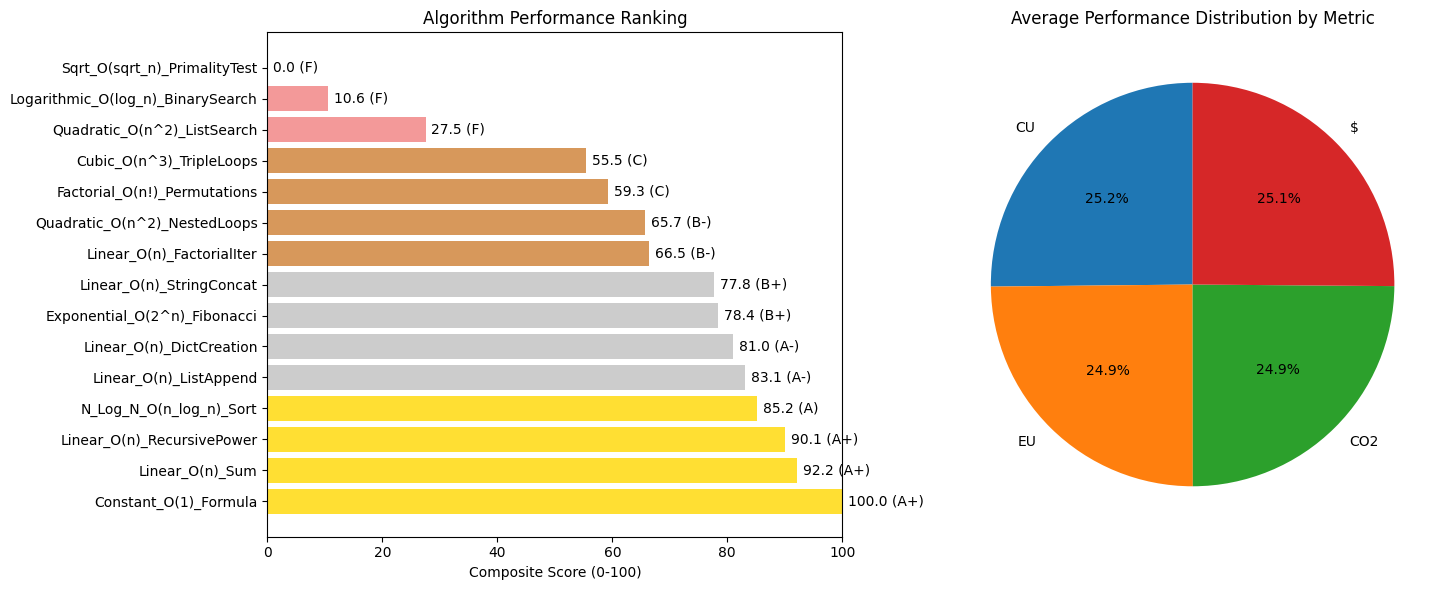

  > Chart is displayed above.

[Chart] Generating comparison charts for each algorithm vs. the best...
  > Baseline for comparison is 'Constant_O(1)_Formula'.
  > Generating chart: comparison_Logarithmic_Olog_n_BinarySearch_vs_Constant_O1_Formula.png


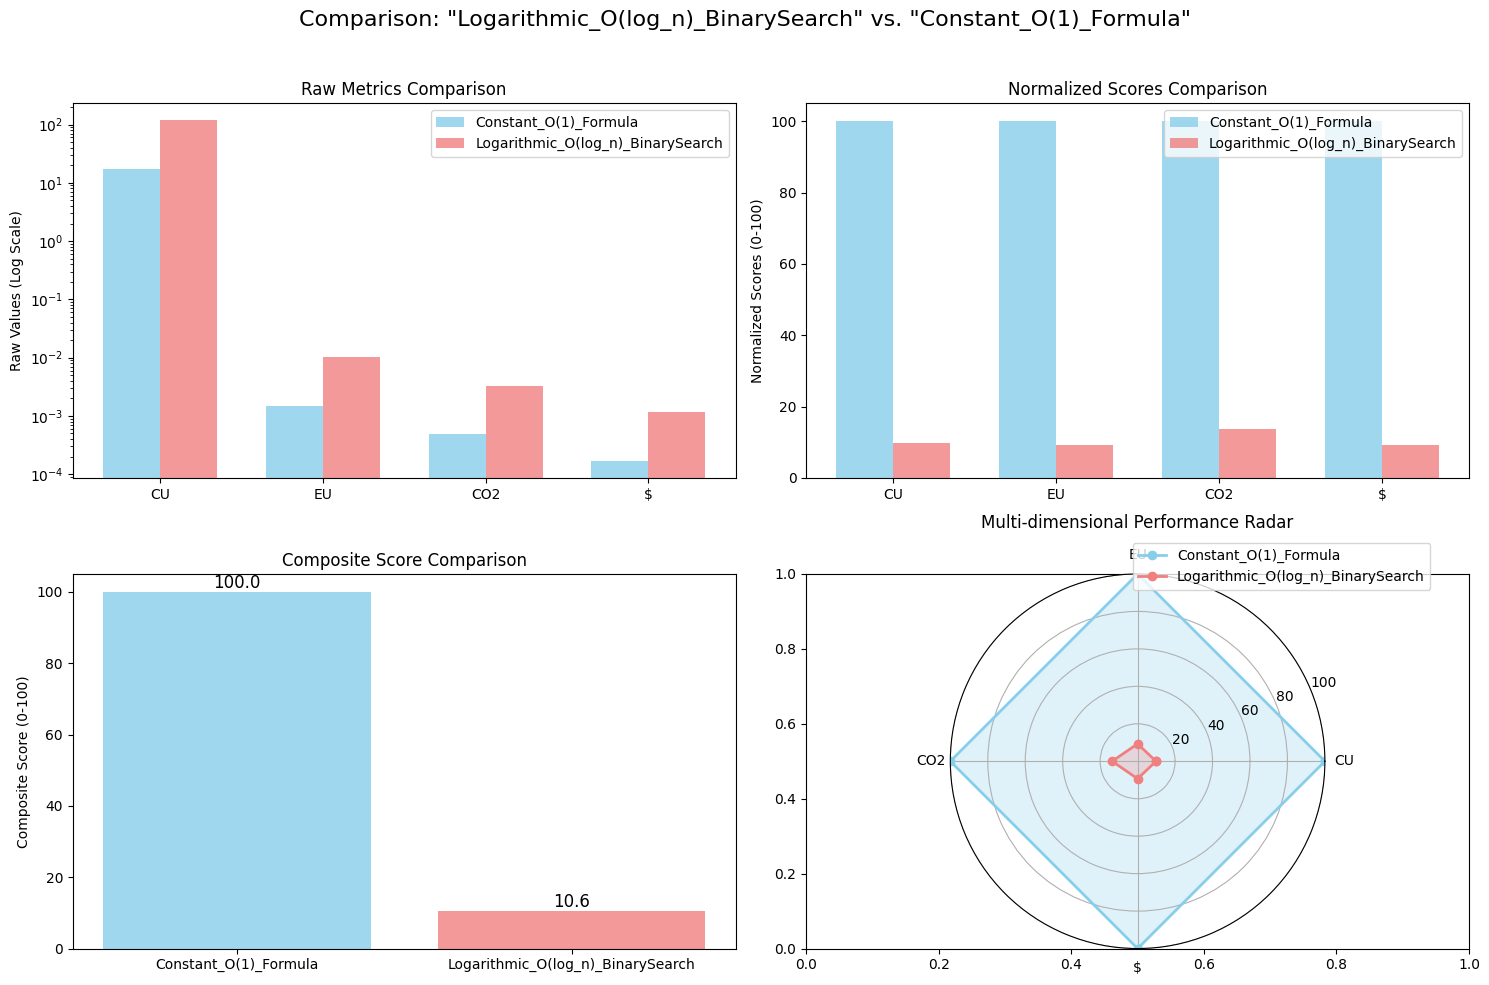

  > Generating chart: comparison_Sqrt_Osqrt_n_PrimalityTest_vs_Constant_O1_Formula.png


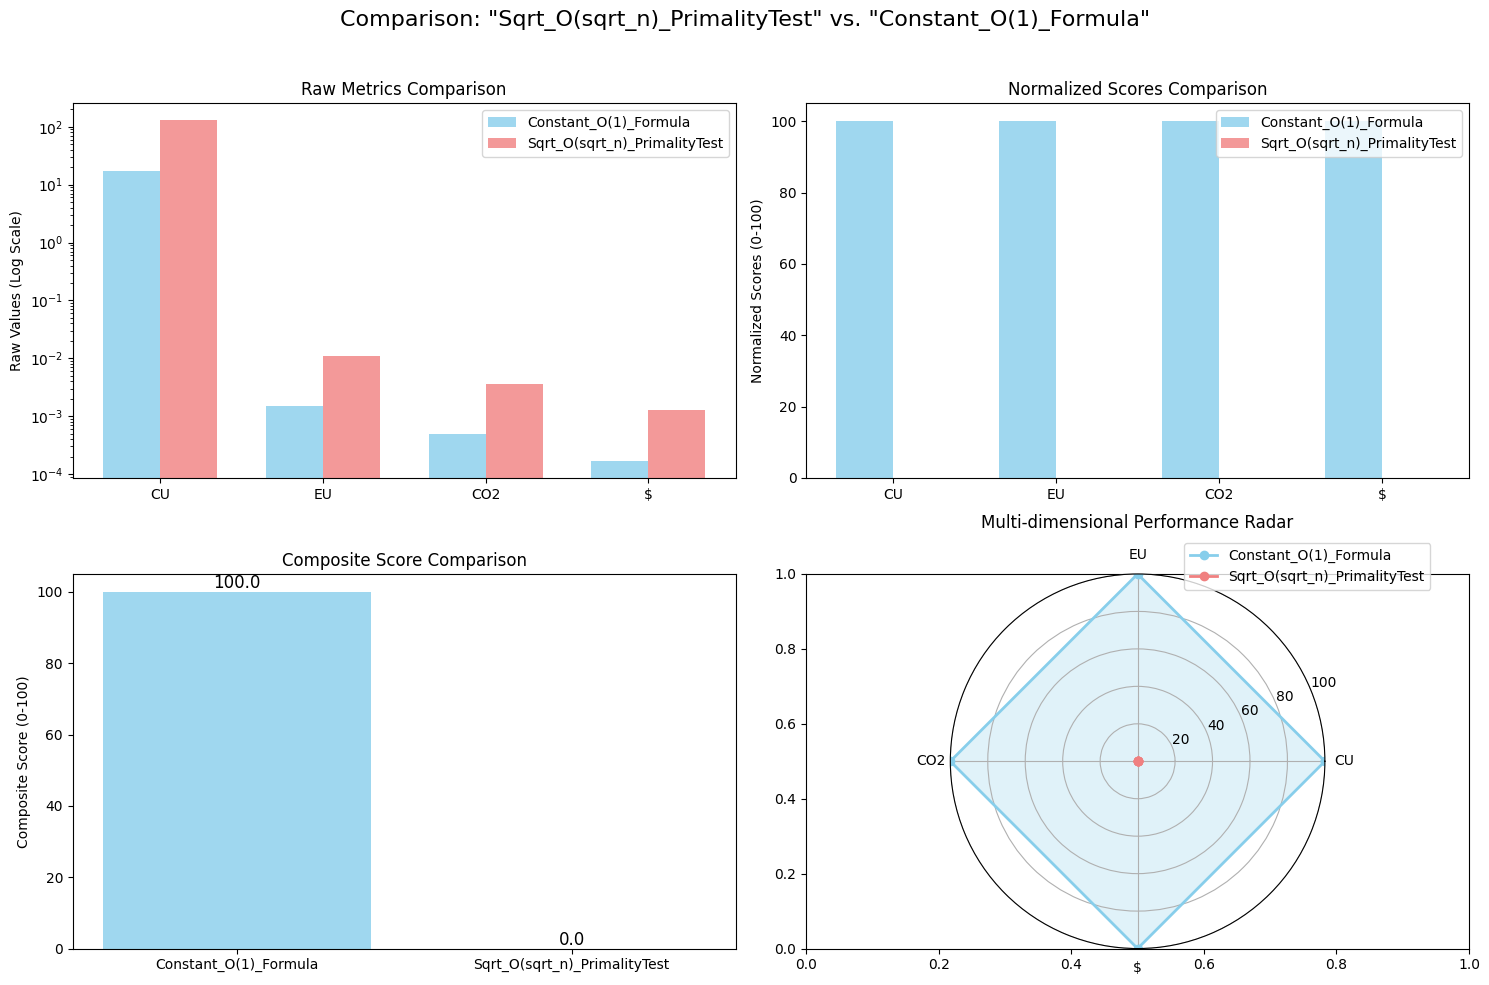

  > Generating chart: comparison_Linear_On_Sum_vs_Constant_O1_Formula.png


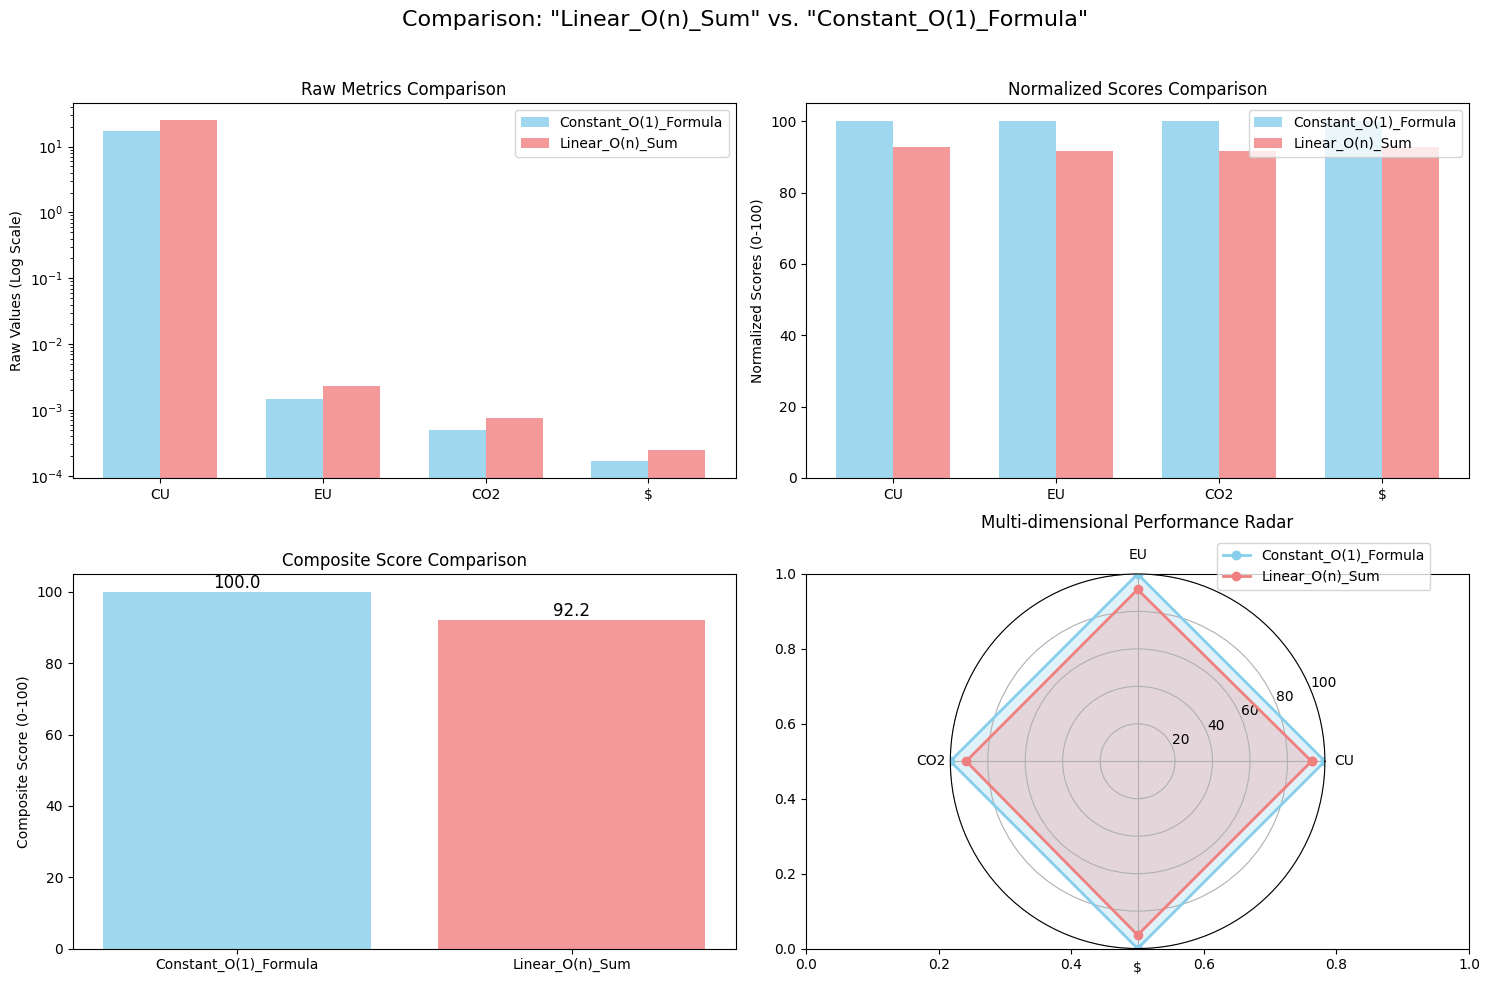

  > Generating chart: comparison_Linear_On_ListAppend_vs_Constant_O1_Formula.png


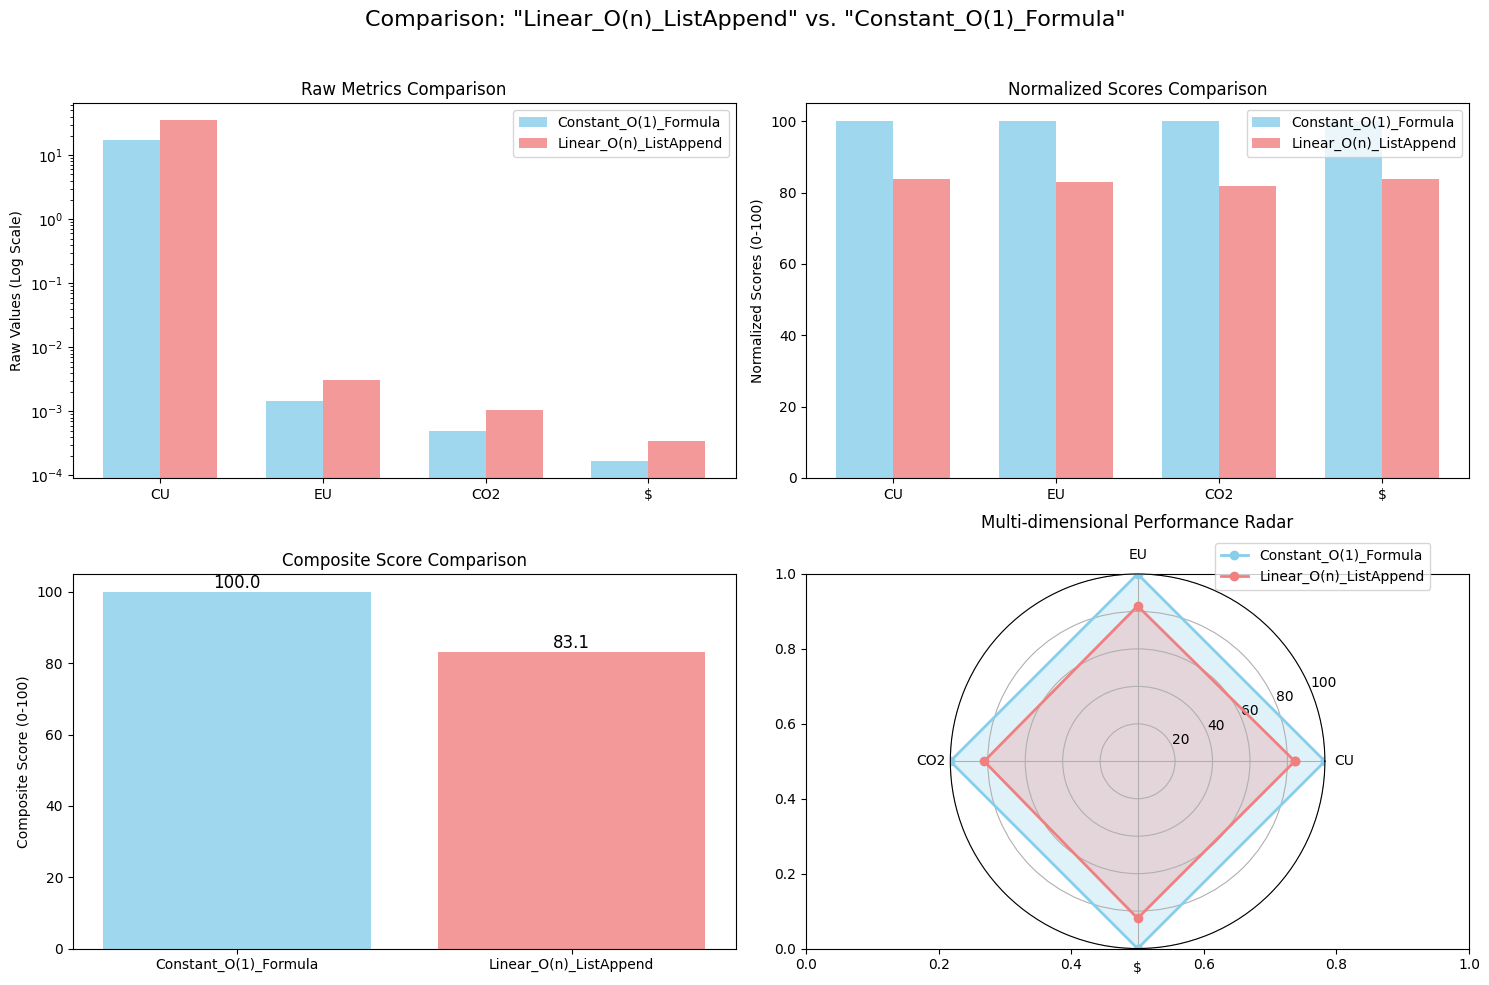

  > Generating chart: comparison_Linear_On_StringConcat_vs_Constant_O1_Formula.png


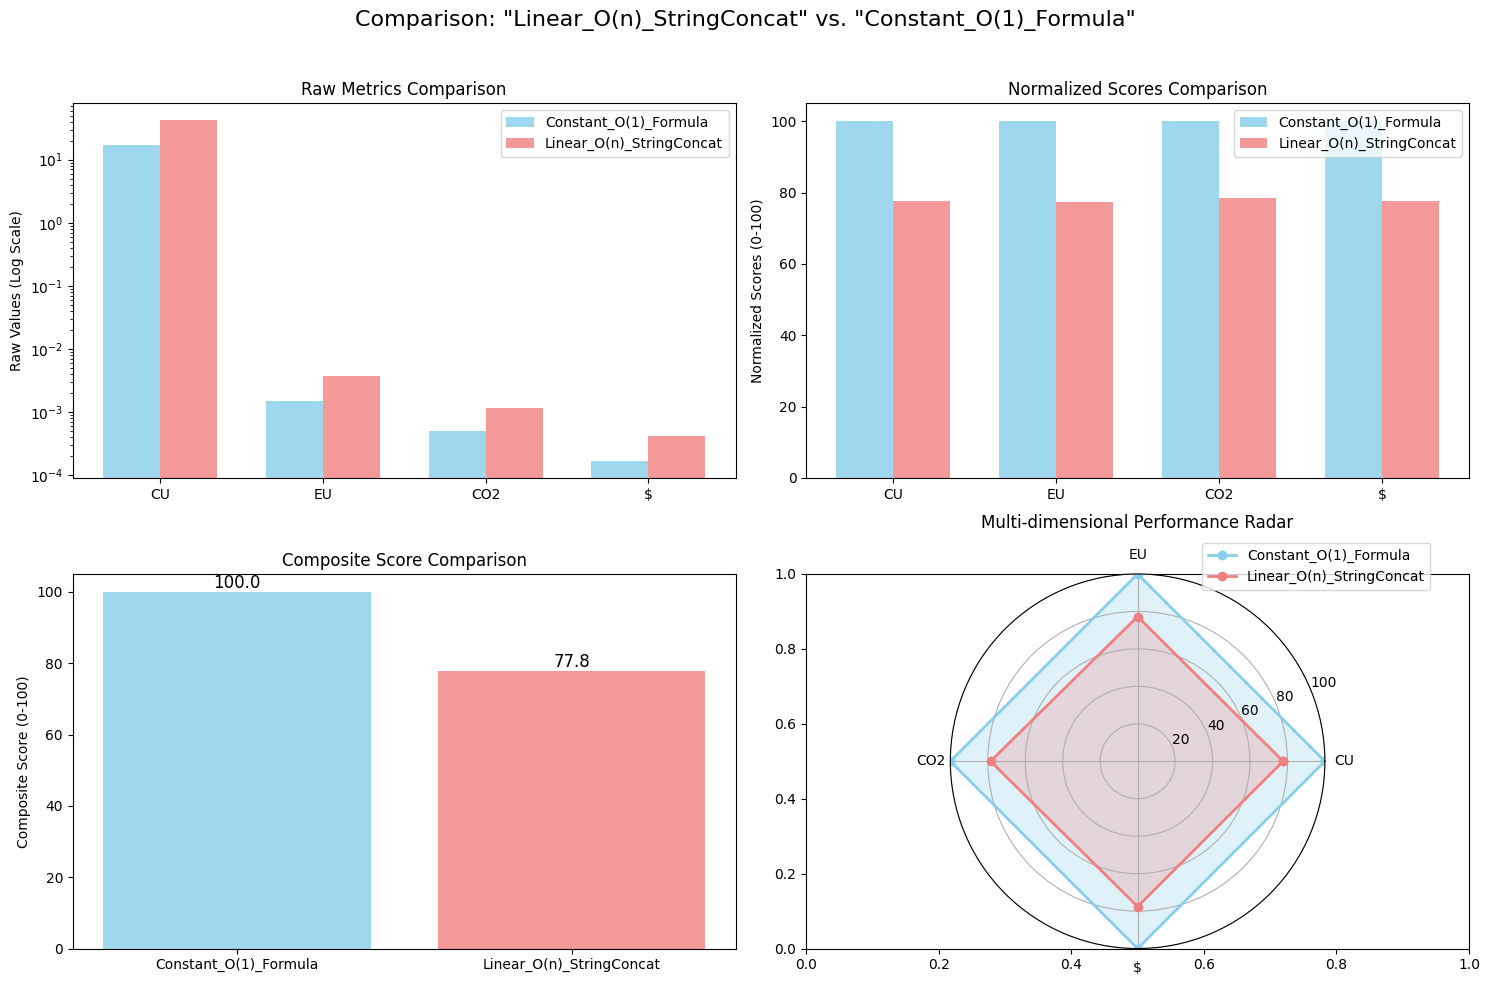

  > Generating chart: comparison_Linear_On_DictCreation_vs_Constant_O1_Formula.png


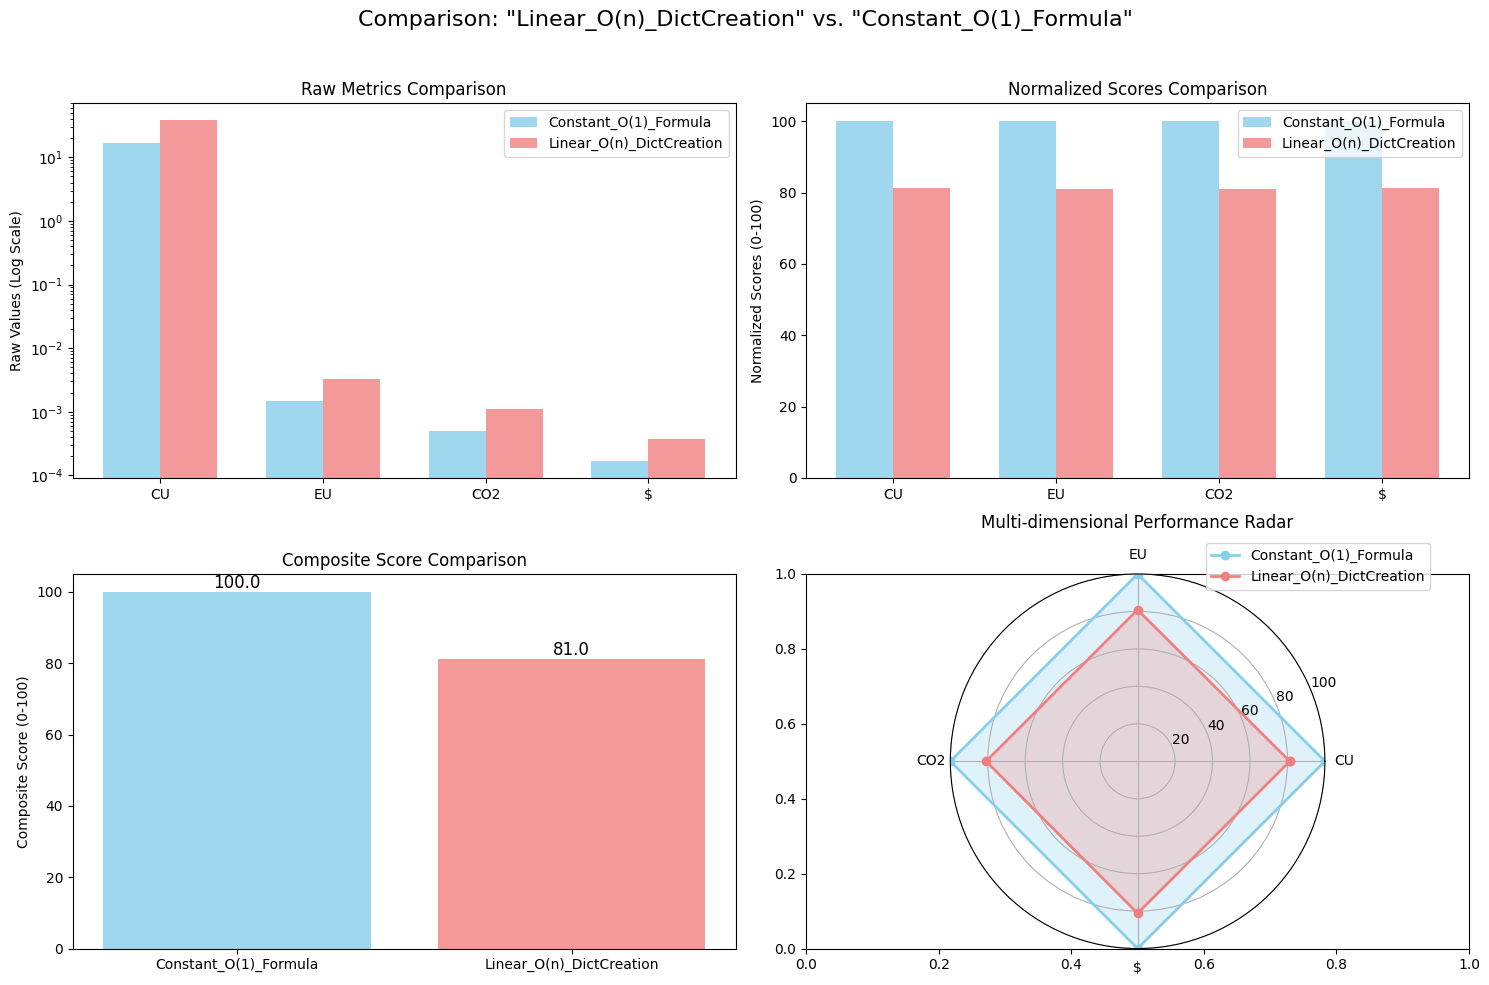

  > Generating chart: comparison_Linear_On_FactorialIter_vs_Constant_O1_Formula.png


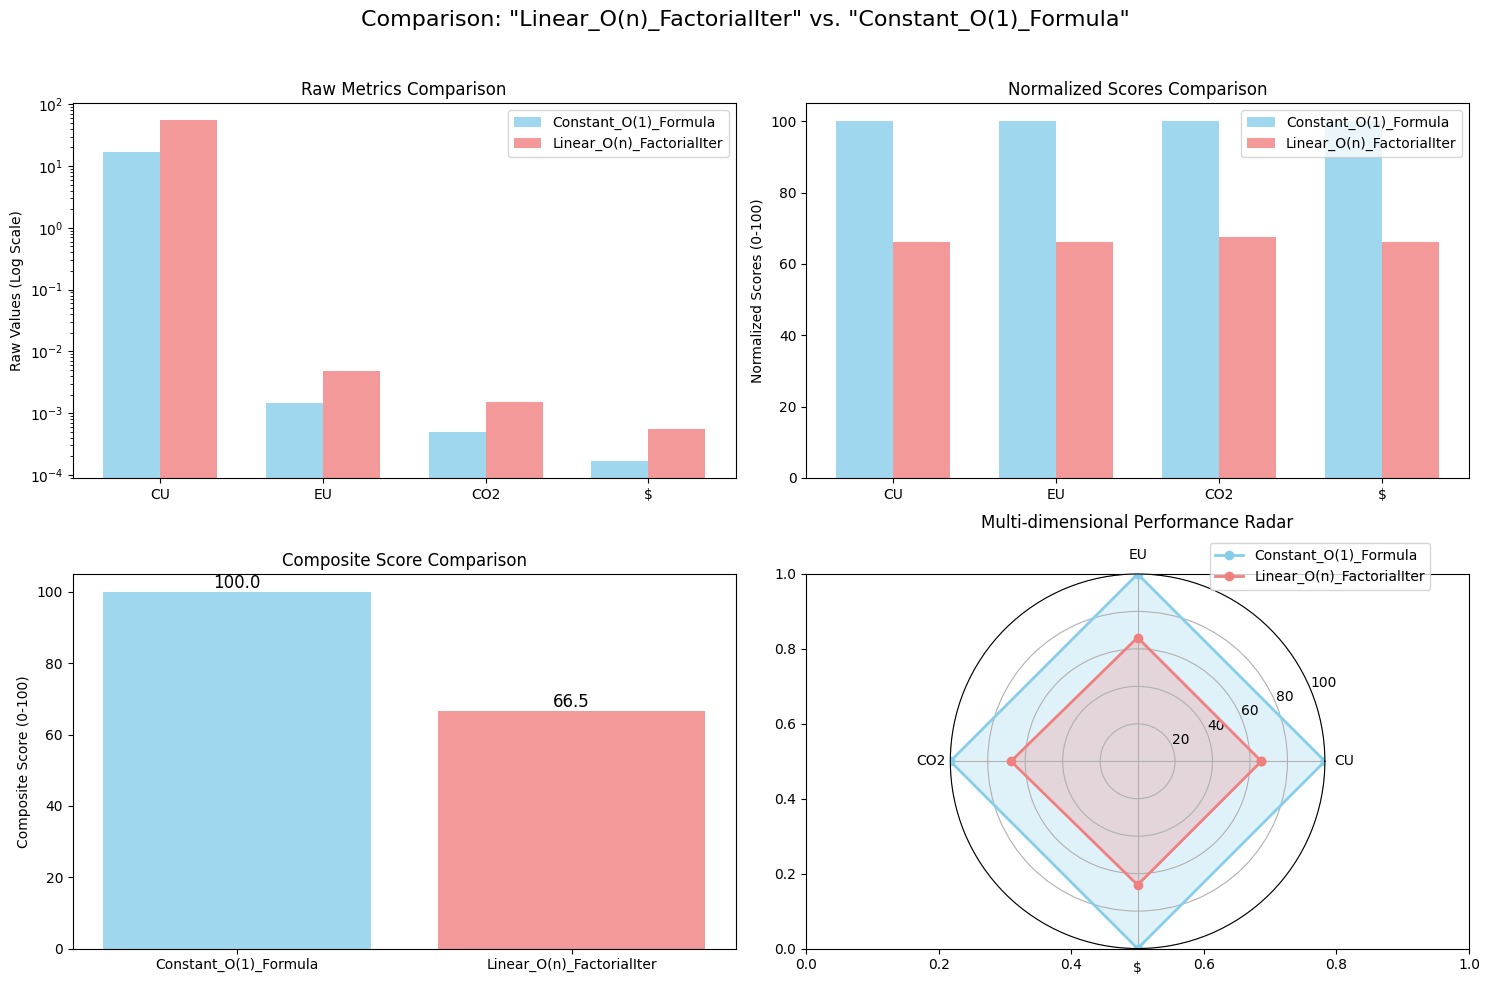

  > Generating chart: comparison_Linear_On_RecursivePower_vs_Constant_O1_Formula.png


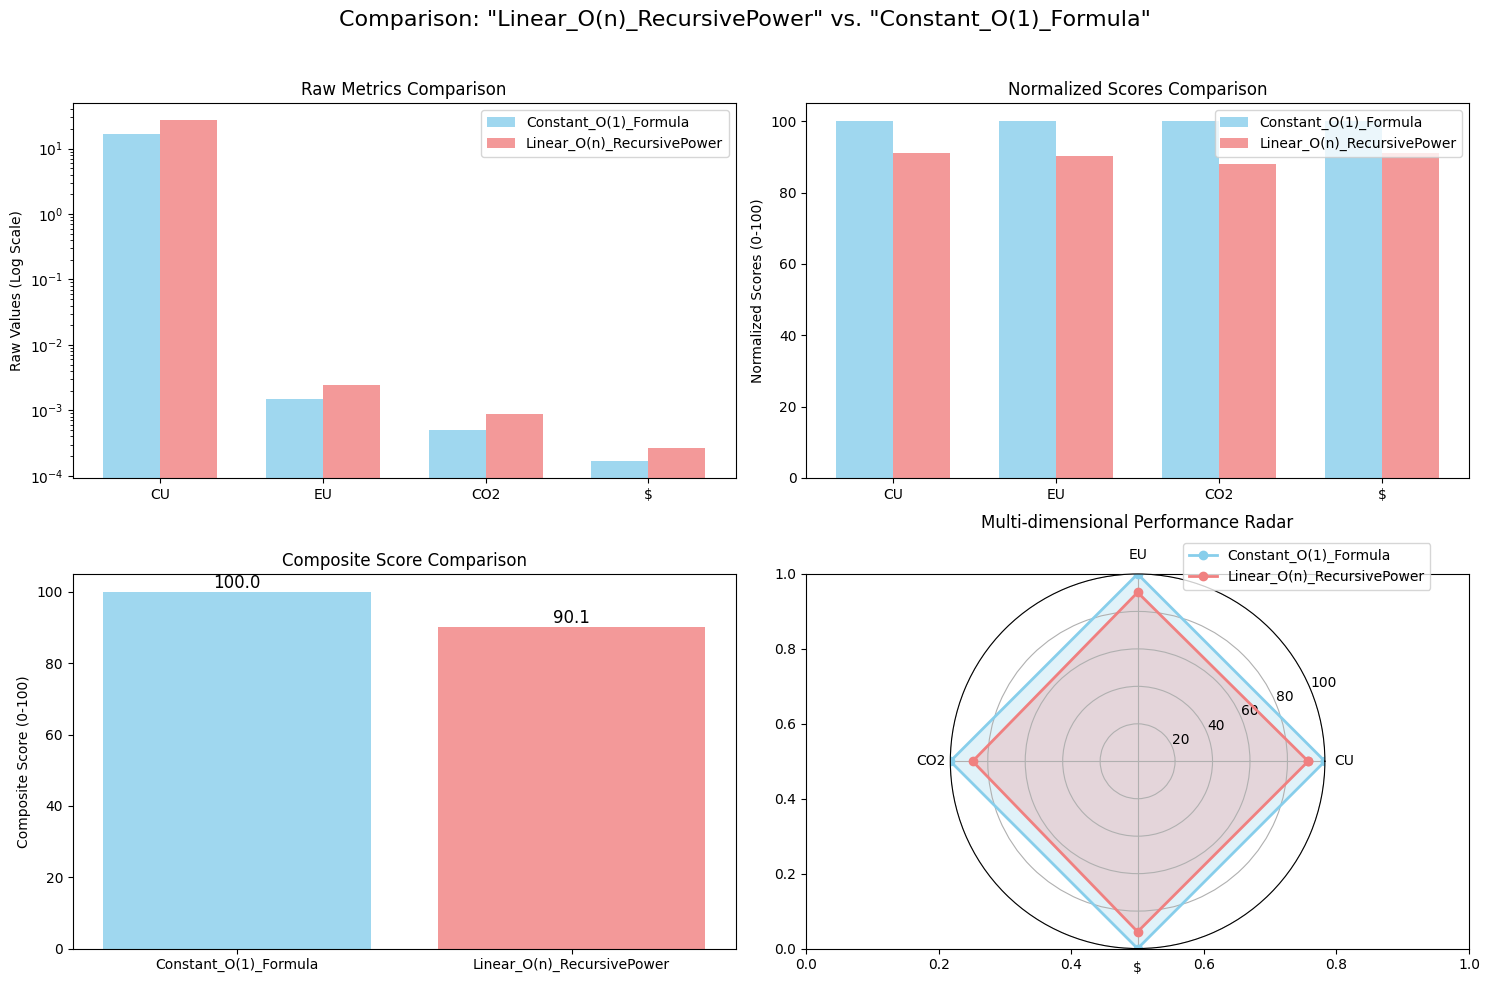

  > Generating chart: comparison_N_Log_N_On_log_n_Sort_vs_Constant_O1_Formula.png


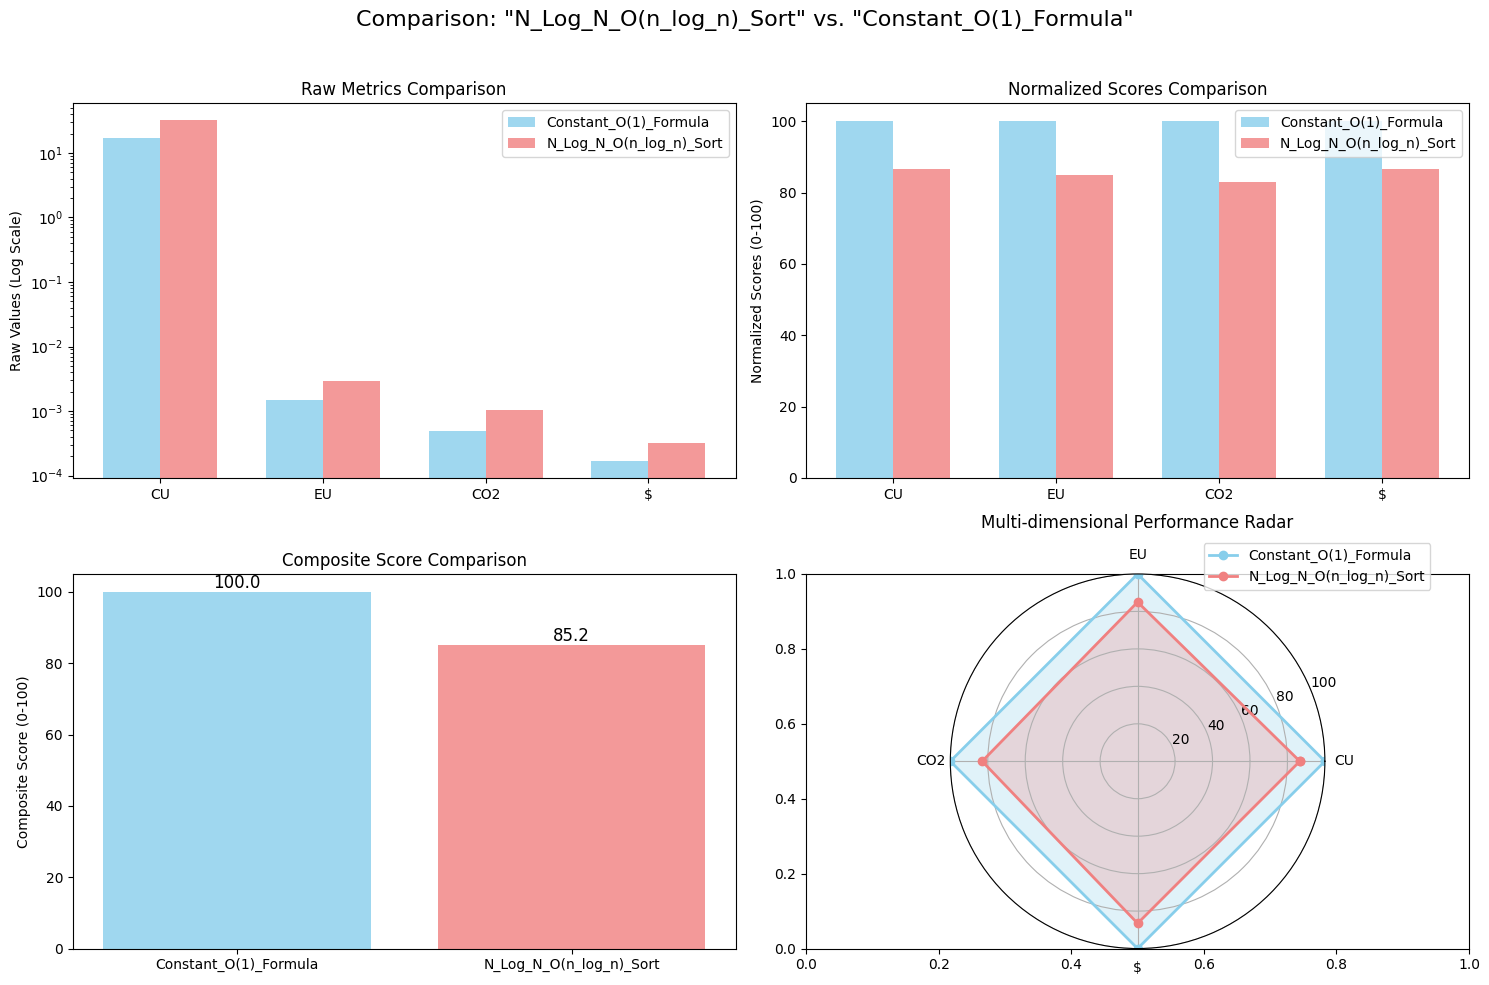

  > Generating chart: comparison_Quadratic_On2_NestedLoops_vs_Constant_O1_Formula.png


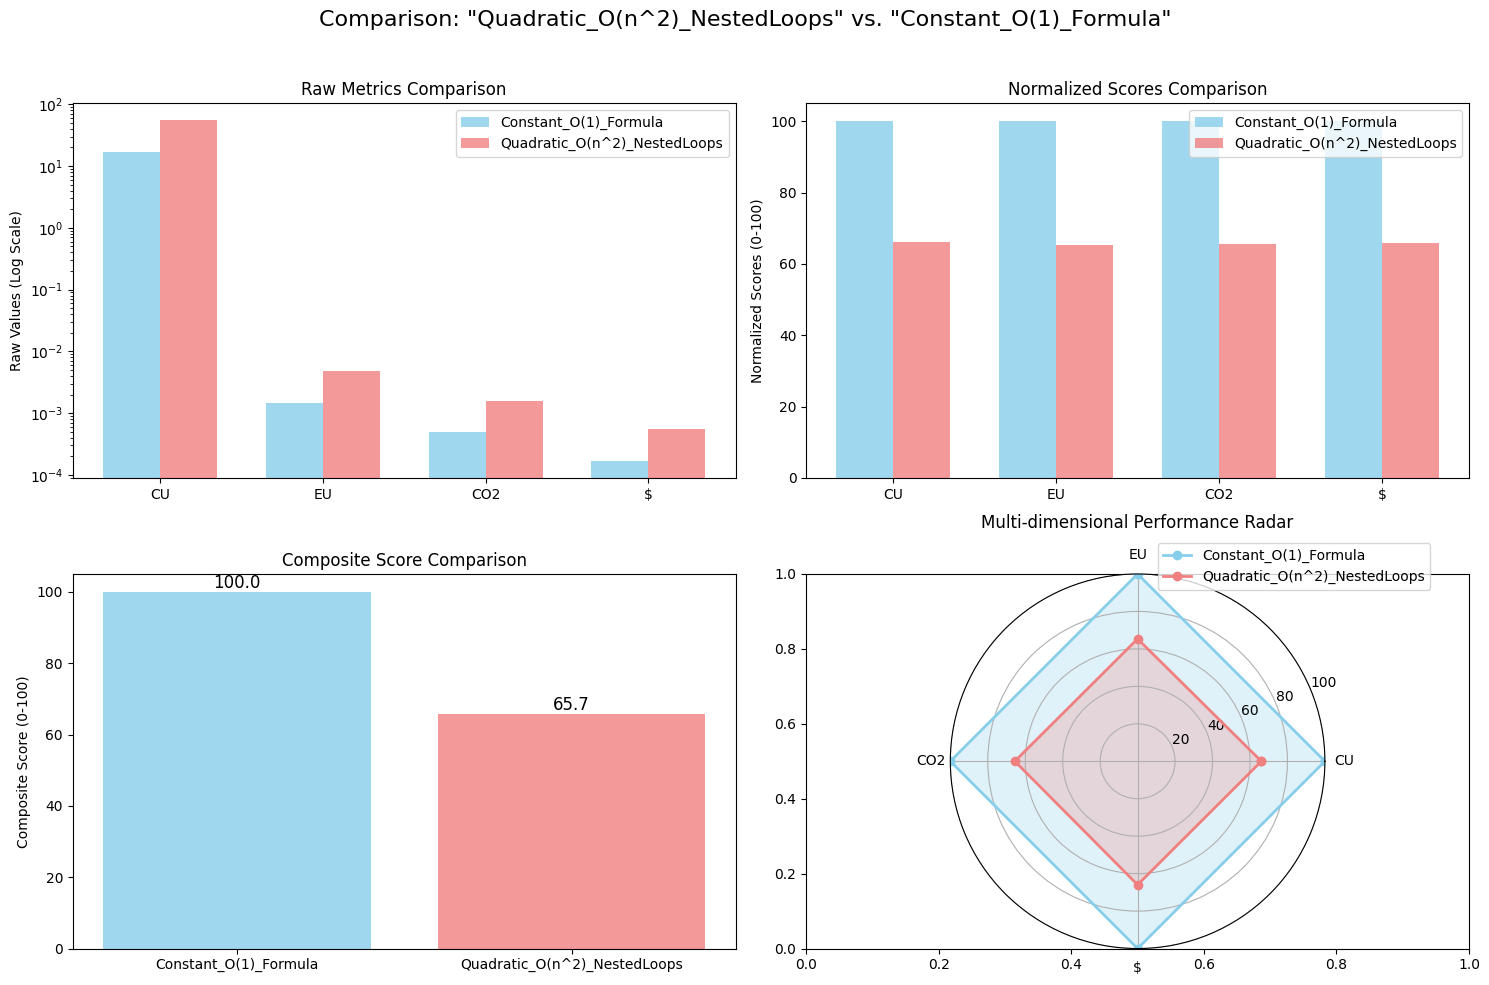

  > Generating chart: comparison_Quadratic_On2_ListSearch_vs_Constant_O1_Formula.png


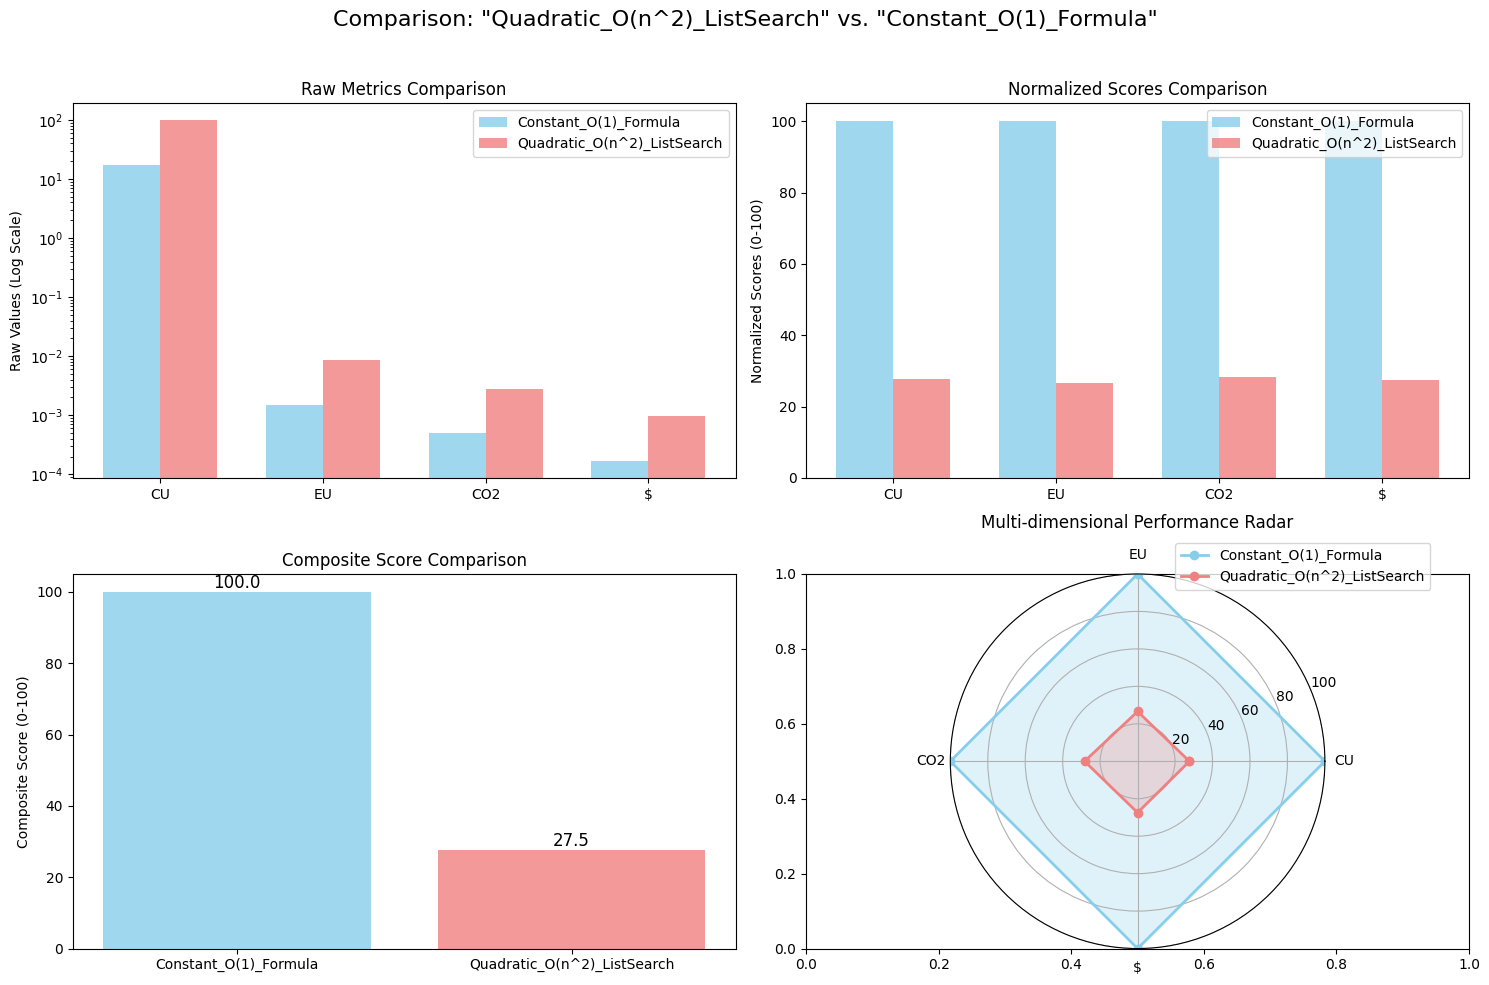

  > Generating chart: comparison_Cubic_On3_TripleLoops_vs_Constant_O1_Formula.png


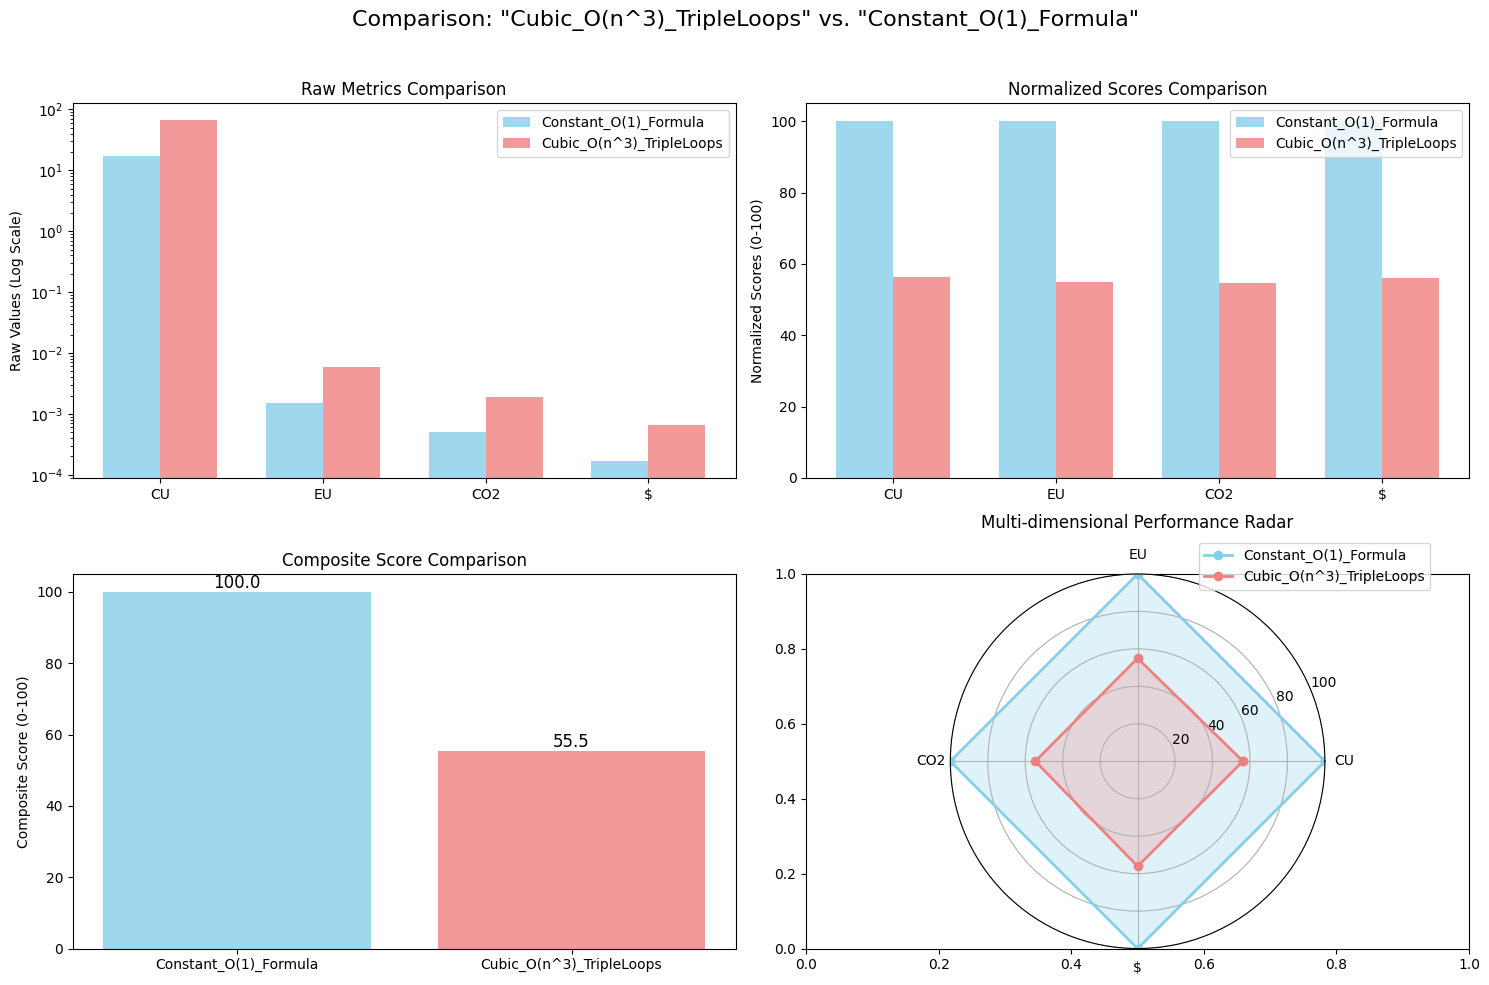

  > Generating chart: comparison_Exponential_O2n_Fibonacci_vs_Constant_O1_Formula.png


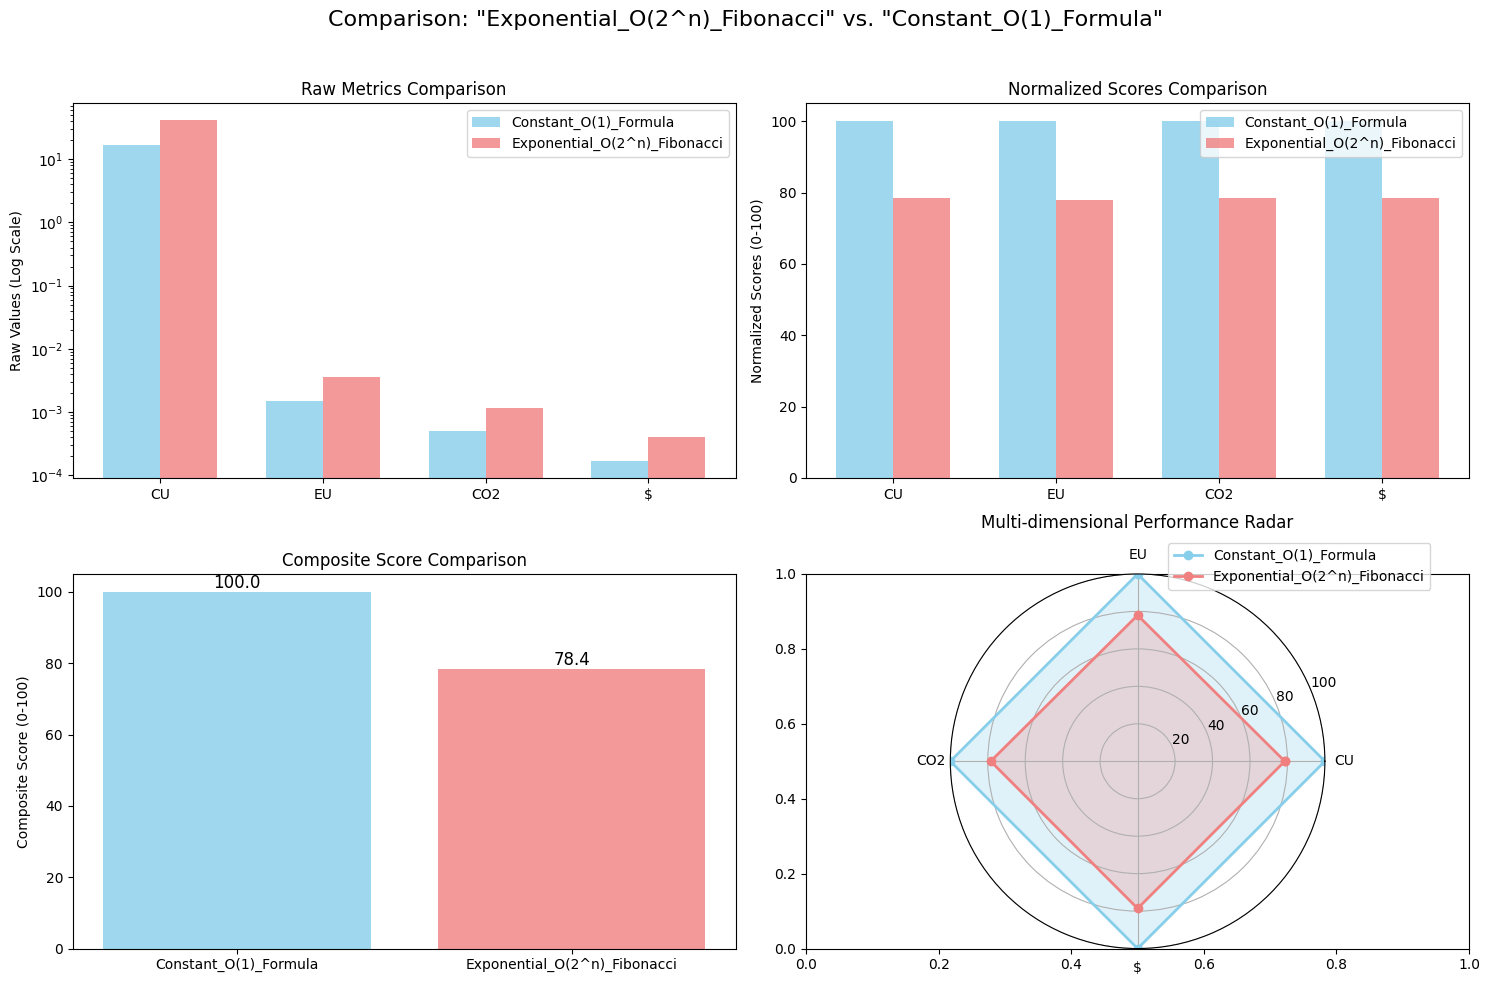

  > Generating chart: comparison_Factorial_On_Permutations_vs_Constant_O1_Formula.png


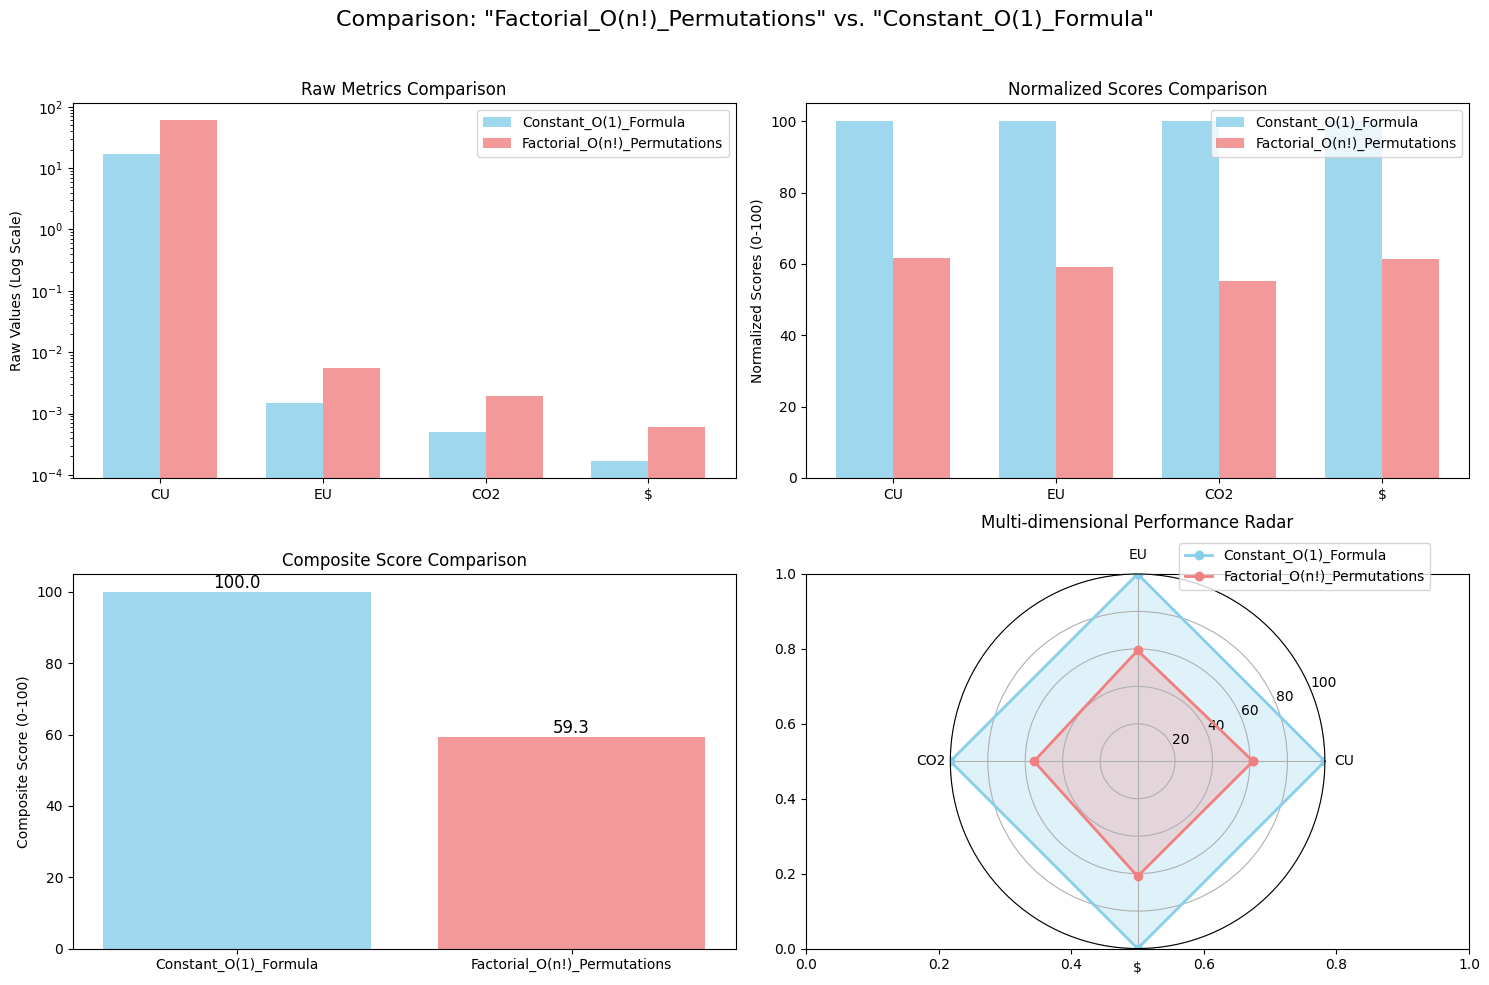

  > All comparison charts have been generated and displayed.

					COMPREHENSIVE SUMMARY REPORT


,Value
Metric,
Analysis Timestamp,Linux-6.1.123+-x86_64-with-glibc2.35
Architecture,x86_64
Profile - Profile,RESEARCH
Profile - Weights,"{'CU': 0.4, 'EU': 0.3, 'CO2': 0.25, '$': 0.05}"
Profile - Description,Research/Academic - focused on performance wit...
Stat - Best Algorithm,Constant_O(1)_Formula
Stat - Worst Algorithm,Sqrt_O(sqrt_n)_PrimalityTest
Stat - Average Composite Score,64.85
Stat - Median Composite Score,77.76



[Info] SAVING_FLAG is set to False. All results and charts are displayed above but not saved to disk.

ANALYSIS AND REPORTING COMPLETE
Analysis results were displayed above. No files were saved.


In [92]:
SAVING_FLAG = False
# --- Reporting and Saving ---

print("\n"*2 + '#'*150 + "\n")
print("\t"*8 + "\033[1mREPORTING AND SAVING RESULTS\033[0m")

# --- 1. Generate All Data and Visualizations (always happens) ---

# a) Generate the summary chart for all algorithms
print("\n[Chart] Generating overall benchmark summary chart...")
create_benchmark_summary_chart(benchmark_results, DEFAULT_REPORT_DIR)
print("  > Chart is displayed above.")

# --- Generate Comparison Charts for All Algorithms ---
print("\n[Chart] Generating comparison charts for each algorithm vs. the best...")

# 1. Identify the baseline algorithm (the best one).
best_algo_name = benchmark_results['statistics']['best_algorithm']
best_algo_results = benchmark_results['results'][best_algo_name]
print(f"  > Baseline for comparison is '{best_algo_name}'.")

# 2. IMPORTANT: Create the main reports directory BEFORE the loop.
# The REPORT_DIR variable comes from the main script context (e.g., "enhanced_reports").
os.makedirs(DEFAULT_REPORT_DIR, exist_ok=True)

# 3. Loop through all algorithms and generate a chart for each one.
for current_algo_name, current_algo_results in benchmark_results['results'].items():

    if current_algo_name == best_algo_name:
        continue

    safe_current_name = make_safe_filename(current_algo_name)
    safe_best_name = make_safe_filename(best_algo_name)
    chart_filename = f"comparison_{safe_current_name}_vs_{safe_best_name}.png"

    # Construct the full, final path for the image file.
    output_filepath = os.path.join(DEFAULT_REPORT_DIR, chart_filename)

    print(f"  > Generating chart: {chart_filename}")

    # Call the updated chart function with the full file path.
    create_enhanced_comparison_chart(
        result1=best_algo_results,
        result2=current_algo_results,
        output_filepath=DEFAULT_REPORT_DIR, # Pass the full path
        names=(best_algo_name, current_algo_name)
    )

print("  > All comparison charts have been generated and displayed.")



# --- Generate and Display Comprehensive Summary Report ---

print("\n" + "="*110)
print("\t"*5 + "\033[1mCOMPREHENSIVE SUMMARY REPORT\033[0m")
print("="*110)

# 1. Prepare all the data components (no change here)
best_algo_name = benchmark_results['statistics']['best_algorithm']
worst_algo_name = benchmark_results['statistics']['worst_algorithm']
best_algo_results = benchmark_results['results'][best_algo_name]
worst_algo_results = benchmark_results['results'][worst_algo_name]

# 2. Create the summary_report dictionary as before
summary_report = {
    "analysis_timestamp": platform.platform(),
    "architecture": detected_arch,
    "profile_used": profile_info,
    "benchmark_summary_stats": benchmark_results["statistics"],
    "best_algorithm_details": best_algo_results,
    "worst_algorithm_details": worst_algo_results,
    "recommendations": generate_recommendations(benchmark_results, profile_info)
}

# 3. Flatten the complex dictionary into a list of [key, value] pairs for the DataFrame
report_data_list = []

# a) Add top-level info
report_data_list.append(['Analysis Timestamp', summary_report['analysis_timestamp']])
report_data_list.append(['Architecture', summary_report['architecture']])

# b) Unroll the 'profile_used' dictionary
for key, value in summary_report['profile_used'].items():
    # Make keys more descriptive, e.g., "Profile - Description"
    descriptive_key = f"Profile - {key.replace('_', ' ').capitalize()}"
    report_data_list.append([descriptive_key, str(value)])

# c) Unroll the 'benchmark_summary_stats' dictionary
for key, value in summary_report['benchmark_summary_stats'].items():
    descriptive_key = f"Stat - {key.replace('_', ' ').title()}"
    # Format numbers for better display
    formatted_value = f"{value:.2f}" if isinstance(value, float) else value
    report_data_list.append([descriptive_key, formatted_value])

# d) Unroll the 'recommendations' list
for i, rec_text in enumerate(summary_report['recommendations']):
    report_data_list.append([f'Recommendation #{i+1}', rec_text])

# e) Unroll details for the BEST algorithm
for key, value in summary_report['best_algorithm_details'].items():
    if key == 'Algorithm': continue # Skip redundant name
    descriptive_key = f"Best Algo ({best_algo_name}) - {key}"
    formatted_value = f"{value:g}" if isinstance(value, float) else value
    report_data_list.append([descriptive_key, formatted_value])

# f) Unroll details for the WORST algorithm
for key, value in summary_report['worst_algorithm_details'].items():
    if key == 'Algorithm': continue # Skip redundant name
    descriptive_key = f"Worst Algo ({worst_algo_name}) - {key}"
    formatted_value = f"{value:g}" if isinstance(value, float) else value
    report_data_list.append([descriptive_key, formatted_value])


# 4. Create and display the DataFrame
summary_df = pd.DataFrame(report_data_list, columns=['Metric', 'Value'])
summary_df.set_index('Metric', inplace=True)
display(summary_df)


# --- 2. Handle File Saving Operations based on SAVING_FLAG ---

if not SAVING_FLAG:
    # If not saving, just print a confirmation that visuals were displayed.
    print("\n[Info] SAVING_FLAG is set to False. All results and charts are displayed above but not saved to disk.")

    # Clean up any dummy files created by chart functions if they don't check for a flag themselves.
    # This prevents cluttering the directory when not saving.
    # if os.path.exists(DEFAULT_REPORT_DIR):
    #     try:
    #         shutil.rmtree(DEFAULT_REPORT_DIR)
    #         print(f"[Info] Temporary directory '{DEFAULT_REPORT_DIR}' cleaned up.")
    #     except OSError as e:
    #         print(f"Error cleaning up directory {DEFAULT_REPORT_DIR}: {e.strerror}")

else:
    # If saving is enabled, proceed with all file I/O operations.
    print(f"\n[Info] SAVING_FLAG is True. Saving all reports to directory: '{DEFAULT_REPORT_DIR}'")

    # The directory is already created by the charting functions, so we just confirm.
    os.makedirs(DEFAULT_REPORT_DIR, exist_ok=True)

    # a) Save main DataFrames as CSV files
    results_df.to_csv(os.path.join(DEFAULT_REPORT_DIR, "01_full_benchmark_summary.csv"))
    comparison_df.to_csv(os.path.join(DEFAULT_REPORT_DIR, "02_comparison_vs_best.csv"))
    print("  > Saved main DataFrames to CSV.")

    # b) Save raw results dictionaries as JSON files
    with open(os.path.join(DEFAULT_REPORT_DIR, "03_benchmark_suite_raw_data.json"), "w", encoding='utf-8') as f:
        json.dump(benchmark_results, f, indent=4)
    print("  > Saved raw benchmark data to JSON.")

    # c) Save the comprehensive summary report
    with open(os.path.join(DEFAULT_REPORT_DIR, "comprehensive_summary_report.json"), "w", encoding='utf-8') as f:
        json.dump(summary_report, f, indent=4, ensure_ascii=False)
    print("  > Saved comprehensive summary report to JSON.")

    # d) Create a ZIP archive of all generated reports
    print("  > Creating ZIP archive of all reports...")
    try:
        shutil.make_archive(DEFAULT_REPORT_DIR, 'zip', root_dir=DEFAULT_REPORT_DIR)
        print(f"  > Successfully created archive: '{DEFAULT_REPORT_DIR}.zip'")
    except Exception as e:
        print(f"  > Error creating archive: {e}")

# --- Final Confirmation Message ---
print("\n" + "="*80)
print("\033[1mANALYSIS AND REPORTING COMPLETE\033[0m")
if SAVING_FLAG:
    print(f"All reports have been saved in the '{DEFAULT_REPORT_DIR}' directory and compressed into '{DEFAULT_REPORT_DIR}.zip'.")
else:
    print("Analysis results were displayed above. No files were saved.")
print("="*80)

# end